In [3]:
# prendere distillation_dataset_session2 per tutti i video session 2
# mettere emozioni come nuova colonna (ordinare per soggetto e fare hardlabeling delle emozioni)
# merge con distillation_dataset_filtrato per prnedere i mouthpath di ita e sp
# fare i mouth path dei restanti video inglesi

# %% [markdown]
# Pipeline di merge + estrazione mouth_path per EMODB Session 2
# - Ordina i video per soggetto (XXX)
# - Parsing di lingua (EN/IT/SP) ed emozione (0..6) dal filename
# - Merge con distillation_dataset_filtrato per portare mouth_path
# - Estrazione .npy per i rimanenti senza mouth_path (fallback semplice)
# - Salva CSV finale con colonne aggiuntive

# %%
import os, re, sys, json, math, shutil, warnings
from pathlib import Path
import numpy as np
import pandas as pd

try:
    import cv2
except Exception:
    cv2 = None
    warnings.warn("OpenCV non disponibile: l'estrazione fallback verrà saltata.")

from tqdm import tqdm

# === CONFIG ===
SESSION2_CSV   = "NEWEMODB/distillation_dataset_session2.csv"
FILTRATO_CSV   = "NEWEMODB/distillation_dataset_filtrato.csv"
OUT_CSV        = "NEWEMODB/distillation_dataset_session2_merged_mouth.csv"

# Dove salvare i .npy per i video senza mouth_path
MOUTH_BASE_DIR = Path("NEWEMODB/video_path")   # segue lo schema del tuo filtrato
MOUTH_BASE_DIR.mkdir(parents=True, exist_ok=True)

# Eseguire davvero l'estrazione dei mancanti (True/False)
RUN_EXTRACTION = True

# Parametri di estrazione fallback (se non usi il tuo extractor)
FRAME_SIZE = 112        # lato (crop/rescale)
MAX_FRAMES = None       # None = tutti i frame; oppure limita (es. 64)


# === MAPPE ===
EMOTION_MAP = {
    0: "neutro",
    1: "rabbia",
    2: "disgusto",
    3: "paura",
    4: "gioia",
    5: "tristezza",
    6: "sorpresa",
}

LANG_MAP_3TO2 = {"EN": "en", "IT": "it", "SP": "es"}  # SP -> es


# === HELPERS ===
def parse_from_filename(path_str):
    """
    Estrae:
      - subject_id: prime 3 cifre del basename (es. 035)
      - emotion_id: la cifra immediatamente prima della lingua (0..6)
      - lang3: EN/IT/SP
    Esempio: 035_m_022_0_3_EN_2.mp4  -> subject=035, emotion=3, lang3=EN
             035_m_022_0_3_IT_2.mp4  -> subject=035, emotion=3, lang3=IT
    """
    name = os.path.basename(path_str)
    # subject_id: 3 cifre iniziali prima di "_"
    m_subj = re.match(r"^(\d{3})_", name)
    subject_id = m_subj.group(1) if m_subj else "UNK"

    # ..._(digit)_(EN|IT|SP)(_|\.mp4)
    m_e = re.search(r"_(\d)_(EN|IT|SP)(?:_|\.|$)", name)
    if not m_e:
        # backup: prova a trovare la coppia (EN|IT|SP) e prendere numero precedente
        m_lang = re.search(r"_(EN|IT|SP)(?:_|\.|$)", name)
        emotion_id = None
        lang3 = m_lang.group(1) if m_lang else "UNK"
        # prova un'altra regex più permissiva
        m_e2 = re.search(r"_([0-6])_([A-Z]{2})(?:_|\.|$)", name)
        if m_e2:
            emotion_id = int(m_e2.group(1))
            lang3 = m_e2.group(2)
    else:
        emotion_id = int(m_e.group(1))
        lang3 = m_e.group(2)

    lang2 = LANG_MAP_3TO2.get(lang3, "unk")
    emotion_name = EMOTION_MAP.get(emotion_id, "sconosciuta")
    return subject_id, emotion_id, emotion_name, lang3, lang2


def subject_key(path_str):
    """Chiave soggetto per ordinamento e grouping (prime 3 cifre)."""
    name = os.path.basename(path_str)
    m = re.match(r"^(\d{3})_", name)
    return m.group(1) if m else "UNK"


def video_sort_key(path_str):
    """Ordina in modo consistente i video per soggetto (basename alfabetico)."""
    return os.path.basename(path_str)


def ensure_parent_dir(p: Path):
    p.parent.mkdir(parents=True, exist_ok=True)


def extract_mouth_npy_fallback(video_path: str, out_npy: Path,
                               frame_size: int = 112,
                               max_frames: int | None = None) -> bool:
    """
    Estrattore fallback *semplice*:
      - Legge tutti i frame del video
      - Center-crop quadrato + resize a (frame_size, frame_size)
      - Concatena in array (T, H, W) in grayscale
      - Salva .npy (float32 in [0,1])
    Sostituiscilo con il tuo extractor (ROI bocca) se disponibile.
    """
    if cv2 is None:
        return False

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return False

    frames = []
    count = 0
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        # BGR -> Gray
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        h, w = gray.shape
        # center-crop quadrato
        side = min(h, w)
        y0 = (h - side) // 2
        x0 = (w - side) // 2
        crop = gray[y0:y0+side, x0:x0+side]
        # resize
        crop = cv2.resize(crop, (frame_size, frame_size), interpolation=cv2.INTER_AREA)
        frames.append(crop)
        count += 1
        if max_frames is not None and count >= max_frames:
            break
    cap.release()

    if len(frames) == 0:
        return False

    arr = np.stack(frames, axis=0).astype(np.float32) / 255.0  # (T,H,W)
    ensure_parent_dir(out_npy)
    np.save(str(out_npy), arr)
    return True


# === LOAD ===
df_s2 = pd.read_csv(SESSION2_CSV)
df_f  = pd.read_csv(FILTRATO_CSV)

# Normalizza chiave di merge: basename del video
df_s2["video_basename"] = df_s2["video_path"].apply(os.path.basename)
df_f["video_basename"]  = df_f["video_path"].apply(os.path.basename)

# Parsing subject/emotion/lang da filename (session2)
parsed = df_s2["video_path"].apply(parse_from_filename)
df_s2[["subject_id","emotion_id","emotion_name","lang3","lang"]] = pd.DataFrame(parsed.tolist(), index=df_s2.index)

# Ordina per soggetto e poi per basename
df_s2 = df_s2.sort_values(by=["subject_id", "video_basename"]).reset_index(drop=True)
# Crea indice d'ordine per soggetto
df_s2["order_in_subject"] = df_s2.groupby("subject_id").cumcount()

# === MERGE con filtrato (per portare mouth_path dove c'è già) ===
keep_cols_f = ["video_basename", "mouth_path"]
df_f_keep = df_f[keep_cols_f].copy()

df_merged = df_s2.merge(df_f_keep, on="video_basename", how="left")

print(f"[INFO] Session2 tot: {len(df_s2)}  | con mouth_path già presente: {df_merged['mouth_path'].notna().sum()}")

# === ESTRARRE i MANCANTI ===
missing = df_merged[df_merged["mouth_path"].isna()].copy()
print(f"[INFO] Mancano mouth_path per {len(missing)} video.")

if RUN_EXTRACTION and len(missing) > 0:
    if cv2 is None:
        print("[WARN] OpenCV non disponibile, salto estrazione fallback.")
    else:
        for i, row in tqdm(missing.iterrows(), total=len(missing), desc="Estrazione fallback .npy"):
            vpath = row["video_path"]
            out_npy = MOUTH_BASE_DIR / f"{os.path.basename(vpath)}.npy"
            ok = extract_mouth_npy_fallback(vpath, out_npy,
                                            frame_size=FRAME_SIZE,
                                            max_frames=MAX_FRAMES)
            if ok:
                df_merged.loc[row.name, "mouth_path"] = str(out_npy)
            else:
                df_merged.loc[row.name, "mouth_path"] = np.nan  # lascia NaN se fallito

# Report finale
have_mouth = df_merged["mouth_path"].notna().sum()
print(f"[DONE] mouth_path disponibili: {have_mouth} / {len(df_merged)}")

# Salva CSV finale
df_merged.to_csv(OUT_CSV, index=False)
print(f"[SAVED] {OUT_CSV}")

# Anteprima per verifica
display_cols = ["subject_id","order_in_subject","video_basename","lang3","lang","emotion_id","emotion_name","mouth_path"]
print(df_merged[display_cols].head(20).to_string(index=False))


[INFO] Session2 tot: 822  | con mouth_path già presente: 195
[INFO] Mancano mouth_path per 627 video.


Estrazione fallback .npy: 100%|██████████| 627/627 [24:37<00:00,  2.36s/it]

[DONE] mouth_path disponibili: 822 / 822
[SAVED] NEWEMODB/distillation_dataset_session2_merged_mouth.csv
subject_id  order_in_subject         video_basename lang3 lang  emotion_id emotion_name                                     mouth_path
       002                 0 002_m_022_0_0_EN_2.mp4    EN   en           0       neutro NEWEMODB/video_path/002_m_022_0_0_EN_2.mp4.npy
       002                 1 002_m_022_0_0_IT_2.mp4    IT   it           0       neutro NEWEMODB/video_path/002_m_022_0_0_IT_2.mp4.npy
       002                 2 002_m_022_0_1_EN_2.mp4    EN   en           1       rabbia NEWEMODB/video_path/002_m_022_0_1_EN_2.mp4.npy
       002                 3 002_m_022_0_1_IT_2.mp4    IT   it           1       rabbia NEWEMODB/video_path/002_m_022_0_1_IT_2.mp4.npy
       002                 4 002_m_022_0_2_EN_2.mp4    EN   en           2     disgusto NEWEMODB/video_path/002_m_022_0_2_EN_2.mp4.npy
       002                 5 002_m_022_0_2_IT_2.mp4    IT   it           2     disgus

In [6]:
# %% [markdown]
# === STEP 1: Split subject-disjoint (Full-Emotion + Neutral-Only) ===

import os, pandas as pd, numpy as np
from pathlib import Path
from sklearn.model_selection import StratifiedGroupKFold

# ====== CONFIG ======
DATASET_CSV = "NEWEMODB/distillation_dataset_emotion.csv"  # cambia se il nome è diverso
OUT_DIR = Path("splits_session2")
N_SPLITS = 5
FOLD = 0     # puoi scegliere 0..N_SPLITS-1
VAL_RATIO = 0.2  # percentuale del train che va a val (sempre subject-disjoint)

OUT_DIR.mkdir(parents=True, exist_ok=True)

# colonne attese: video_path, audio_path, lang, emotion (o emotion_id), subject_id, group, mouth_path
df = pd.read_csv(DATASET_CSV)

# Sanity check minimi
need_cols = ["video_path","audio_path","lang","subject_id"]
for c in need_cols:
    if c not in df.columns:
        raise ValueError(f"Colonna mancante nel CSV: {c}")

# Normalizza colonne emotion
if "emotion" not in df.columns and "emotion_id" in df.columns:
    df["emotion"] = df["emotion_id"].map({
        0:"neutro",1:"rabbia",2:"disgusto",3:"paura",4:"gioia",5:"tristezza",6:"sorpresa"
    })
elif "emotion" in df.columns and "emotion_id" not in df.columns:
    EMO2ID = {"neutro":0,"rabbia":1,"disgusto":2,"paura":3,"gioia":4,"tristezza":5,"sorpresa":6}
    df["emotion_id"] = df["emotion"].map(EMO2ID)

# normalizza lang a {en,it,es}
df["lang"] = df["lang"].str.lower().replace({"sp":"es","es":"es","it":"it","en":"en"})

# normalizza group se presente
if "group" not in df.columns:
    df["group"] = "UNK"
df["group"] = df["group"].astype(str)

# Chiave di stratificazione (lingua × emozione × gruppo)
df["cell"] = df["lang"] + "__" + df["emotion"].astype(str) + "__" + df["group"]

# Svuota righe con info critiche mancanti
df = df.dropna(subset=["subject_id","lang","emotion"]).reset_index(drop=True)

print("[INFO] Totale clip:", len(df))
print(df[["lang","emotion","group"]].value_counts().sort_index().to_string())

# ====== SPLIT PER SOGGETTO (subject-disjoint) ======
sgkf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)
splits = list(sgkf.split(df, y=df["cell"], groups=df["subject_id"]))
train_idx, test_idx = splits[FOLD]
train_df, test_df = df.iloc[train_idx].copy(), df.iloc[test_idx].copy()

# Dal train ricaviamo una VAL per soggetto
# (prendiamo una quota di soggetti dal train per fare val)
train_subjects = train_df["subject_id"].unique()
n_val_subj = max(1, int(round(len(train_subjects)*VAL_RATIO)))
rng = np.random.RandomState(123)
val_subjects = set(rng.choice(train_subjects, size=n_val_subj, replace=False))
val_mask = train_df["subject_id"].isin(val_subjects)
val_df = train_df[val_mask].copy()
train_df = train_df[~val_mask].copy()

def summarize(tag, ddf):
    print(f"\n[{tag}] n={len(ddf)} | subjects={ddf.subject_id.nunique()}")
    print(ddf[["lang","emotion","group"]].value_counts().sort_index().to_string())

summarize("TRAIN", train_df)
summarize("VAL",   val_df)
summarize("TEST",  test_df)

# Salva Full-Emotion
full_dir = OUT_DIR / f"full_F{FOLD}"
full_dir.mkdir(parents=True, exist_ok=True)
train_df.to_csv(full_dir/"train.csv", index=False)
val_df.to_csv(full_dir/"val.csv", index=False)
test_df.to_csv(full_dir/"test.csv", index=False)
print("\n[SAVED] Full-Emotion splits in:", full_dir)

# ====== VISTA NEUTRAL-ONLY ======
neutral_train = train_df[train_df["emotion_id"]==0].copy()
neutral_val   = val_df[val_df["emotion_id"]==0].copy()
neutral_test  = test_df.copy()   # test rimane misto: serve per 'cross-emotion'

summarize("NEUTRAL-TRAIN", neutral_train)
summarize("NEUTRAL-VAL",   neutral_val)
summarize("NEUTRAL-TEST",  neutral_test)

neutral_dir = OUT_DIR / f"neutral_only_F{FOLD}"
neutral_dir.mkdir(parents=True, exist_ok=True)
neutral_train.to_csv(neutral_dir/"train.csv", index=False)
neutral_val.to_csv(neutral_dir/"val.csv", index=False)
neutral_test.to_csv(neutral_dir/"test.csv", index=False)
print("\n[SAVED] Neutral-Only splits in:", neutral_dir)


[INFO] Totale clip: 822
lang  emotion    group
en    disgusto   UNK      62
      gioia      UNK      61
      neutro     UNK      62
      paura      UNK      61
      rabbia     UNK      61
      sorpresa   UNK      62
      tristezza  UNK      62
es    disgusto   UNK      14
      gioia      UNK      14
      neutro     UNK      14
      paura      UNK      13
      rabbia     UNK      14
      sorpresa   UNK      14
      tristezza  UNK      14
it    disgusto   UNK      42
      gioia      UNK      42
      neutro     UNK      42
      paura      UNK      42
      rabbia     UNK      42
      sorpresa   UNK      42
      tristezza  UNK      42

[TRAIN] n=530 | subjects=40
lang  emotion    group
en    disgusto   UNK      40
      gioia      UNK      40
      neutro     UNK      40
      paura      UNK      39
      rabbia     UNK      40
      sorpresa   UNK      40
      tristezza  UNK      40
es    disgusto   UNK      11
      gioia      UNK      11
      neutro     UNK      11
  

In [13]:
# %% [markdown]
# === STEP 2.b — Teacher mid/top (Whisper encoder layer10 & layer11) ===
# Aggiunge ai CSV: layer10_mean_path, layer11_mean_path (come nel tuo studio)

import os, json, tempfile
from pathlib import Path
from tqdm import tqdm
import numpy as np
import pandas as pd

import torch
import whisper
import librosa

# === CONFIG ===
CSV_LIST = [
    "splits_session2/full_F0/train.csv",
    "splits_session2/full_F0/val.csv",
    "splits_Session2/full_F0/test.csv",
    "splits_session2/neutral_only_F0/train.csv",
    "splits_session2/neutral_only_F0/val.csv",
    "splits_session2/neutral_only_F0/test.csv",
]
OUT_BASE = Path("teacher_cache/mid_top")
OUT_BASE.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "small"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# === MODEL ===
model = whisper.load_model(MODEL_NAME, device=DEVICE)
enc = model.encoder  # contiene .blocks (lista di ResidualAttentionBlock)

def atomic_save_npy(out_path: Path, arr: np.ndarray):
    out_path = out_path.with_suffix(".npy")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    with tempfile.NamedTemporaryFile(dir=str(out_path.parent), delete=False) as tmp:
        np.save(tmp, arr.astype(np.float32))
        tmp.flush(); os.fsync(tmp.fileno())
    os.replace(tmp.name, str(out_path))

def load_audio_16k(path: str) -> np.ndarray:
    wav, sr = librosa.load(path, sr=16000, mono=True)
    return wav.astype(np.float32, copy=False)

@torch.no_grad()
def teacher_mid_top(wav16k: np.ndarray):
    mel = whisper.log_mel_spectrogram(
        whisper.pad_or_trim(torch.tensor(wav16k))
    ).to(DEVICE)

    # hook su layer10 e layer11 (0-indexed)
    feats_l10, feats_l11 = [], []
    def hook10(_m, _i, o): feats_l10.append(o.detach().mean(dim=1).squeeze(0).float().cpu().numpy())  # (C,)
    def hook11(_m, _i, o): feats_l11.append(o.detach().mean(dim=1).squeeze(0).float().cpu().numpy())  # (C,)

    h10 = enc.blocks[10].register_forward_hook(hook10)
    h11 = enc.blocks[11].register_forward_hook(hook11)

    _ = enc(mel.unsqueeze(0))  # forward encoder: attiva gli hook

    h10.remove(); h11.remove()
    v10 = feats_l10[0] if feats_l10 else None
    v11 = feats_l11[0] if feats_l11 else None
    return v10, v11

def process_csv(csv_path: str):
    df = pd.read_csv(csv_path)
    if "audio_path" not in df.columns:
        raise ValueError(f"{csv_path}: manca 'audio_path'.")

    add_cols = ["layer10_mean_path","layer11_mean_path"]
    for c in add_cols:
        if c not in df.columns: df[c] = np.nan

    for i, r in tqdm(df.iterrows(), total=len(df), desc=f"mid/top: {Path(csv_path).name}"):
        ap = r["audio_path"]
        if not isinstance(ap, str) or not os.path.exists(ap):
            continue
        try:
            wav = load_audio_16k(ap)
            v10, v11 = teacher_mid_top(wav)
            vb = os.path.basename(r.get("video_path", ap))
            subj = str(r.get("subject_id","UNK"))
            p10 = OUT_BASE / subj / f"{vb}__l10.npy"
            p11 = OUT_BASE / subj / f"{vb}__l11.npy"
            if v10 is not None: atomic_save_npy(p10, v10); df.at[i,"layer10_mean_path"] = str(p10)
            if v11 is not None: atomic_save_npy(p11, v11); df.at[i,"layer11_mean_path"] = str(p11)
        except Exception as ex:
            print(f"[WARN] {ap}: {ex}")

    out_csv = str(Path(csv_path).with_suffix("").as_posix() + "_midtop.csv")
    df.to_csv(out_csv, index=False)
    print(f"[SAVED] {out_csv}")
    return out_csv

OUTS = [process_csv(p) for p in CSV_LIST]
print("CSV con mid/top:", OUTS)


mid/top: train.csv:   0%|          | 0/530 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_23627/3311345514.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'teacher_cache/mid_top/5/005_m_026_0_0_EN_2.mp4__l10.npy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  if v10 is not None: atomic_save_npy(p10, v10); df.at[i,"layer10_mean_path"] = str(p10)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_23627/3311345514.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'teacher_cache/mid_top/5/005_m_026_0_0_EN_2.mp4__l11.npy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  if v11 is not None: atomic_save_npy(p11, v11); df.at[i,"layer11_mean_path"] = str(p11)
mid/top: train.csv: 100%|██████████| 530/530 [04:05<00:00,  2.16it/s]

[SAVED] splits_session2/full_F0/train_midtop.csv


mid/top: val.csv:   0%|          | 0/125 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_23627/3311345514.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'teacher_cache/mid_top/2/002_m_022_0_0_EN_2.mp4__l10.npy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  if v10 is not None: atomic_save_npy(p10, v10); df.at[i,"layer10_mean_path"] = str(p10)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_23627/3311345514.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'teacher_cache/mid_top/2/002_m_022_0_0_EN_2.mp4__l11.npy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  if v11 is not None: atomic_save_npy(p11, v11); df.at[i,"layer11_mean_path"] = str(p11)
mid/top: val.csv: 100%|██████████| 125/125 [00:58<00:00,  2.14it/s]


[SAVED] splits_session2/full_F0/val_midtop.csv


mid/top: test.csv:   0%|          | 0/167 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_23627/3311345514.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'teacher_cache/mid_top/3/003_f_021_0_0_EN_2.mp4__l10.npy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  if v10 is not None: atomic_save_npy(p10, v10); df.at[i,"layer10_mean_path"] = str(p10)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_23627/3311345514.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'teacher_cache/mid_top/3/003_f_021_0_0_EN_2.mp4__l11.npy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  if v11 is not None: atomic_save_npy(p11, v11); df.at[i,"layer11_mean_path"] = str(p11)
mid/top: test.csv: 100%|██████████| 167/167 [01:18<00:00,  2.12it/s]


[SAVED] splits_Session2/full_F0/test_midtop.csv


mid/top: train.csv:   0%|          | 0/76 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_23627/3311345514.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'teacher_cache/mid_top/5/005_m_026_0_0_EN_2.mp4__l10.npy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  if v10 is not None: atomic_save_npy(p10, v10); df.at[i,"layer10_mean_path"] = str(p10)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_23627/3311345514.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'teacher_cache/mid_top/5/005_m_026_0_0_EN_2.mp4__l11.npy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  if v11 is not None: atomic_save_npy(p11, v11); df.at[i,"layer11_mean_path"] = str(p11)
mid/top: train.csv: 100%|██████████| 76/76 [00:35<00:00,  2.13it/s]


[SAVED] splits_session2/neutral_only_F0/train_midtop.csv


mid/top: val.csv:   0%|          | 0/18 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_23627/3311345514.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'teacher_cache/mid_top/2/002_m_022_0_0_EN_2.mp4__l10.npy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  if v10 is not None: atomic_save_npy(p10, v10); df.at[i,"layer10_mean_path"] = str(p10)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_23627/3311345514.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'teacher_cache/mid_top/2/002_m_022_0_0_EN_2.mp4__l11.npy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  if v11 is not None: atomic_save_npy(p11, v11); df.at[i,"layer11_mean_path"] = str(p11)
mid/top: val.csv: 100%|██████████| 18/18 [00:08<00:00,  2.12it/s]


[SAVED] splits_session2/neutral_only_F0/val_midtop.csv


mid/top: test.csv:   0%|          | 0/167 [00:00<?, ?it/s]/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_23627/3311345514.py:87: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'teacher_cache/mid_top/3/003_f_021_0_0_EN_2.mp4__l10.npy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  if v10 is not None: atomic_save_npy(p10, v10); df.at[i,"layer10_mean_path"] = str(p10)
/var/folders/jx/nf2g6k1s1550mrw1rrvdw69h0000gn/T/ipykernel_23627/3311345514.py:88: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'teacher_cache/mid_top/3/003_f_021_0_0_EN_2.mp4__l11.npy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  if v11 is not None: atomic_save_npy(p11, v11); df.at[i,"layer11_mean_path"] = str(p11)
mid/top: test.csv: 100%|██████████| 167/167 [01:18<00:00,  2.13it/s]

[SAVED] splits_session2/neutral_only_F0/test_midtop.csv
CSV con mid/top: ['splits_session2/full_F0/train_midtop.csv', 'splits_session2/full_F0/val_midtop.csv', 'splits_Session2/full_F0/test_midtop.csv', 'splits_session2/neutral_only_F0/train_midtop.csv', 'splits_session2/neutral_only_F0/val_midtop.csv', 'splits_session2/neutral_only_F0/test_midtop.csv']


In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# Runner KD (mid/top) — emotion-aware + confidence-gate — CPU only
# Richiede gli split:
#   - splits_session2/full_F0/{train,val,test}_midtop.csv
#   - splits_session2/neutral_only_F0/{train,val,test}_midtop.csv
# Colonne richieste nei CSV: mouth_path, (lang|label), (emotion|emotion_id), t_conf, layer10_mean_path, layer11_mean_path

import os, json, random, copy, math, contextlib, glob
from pathlib import Path
import numpy as np, pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from torchvision.models.video import r3d_18, R3D_18_Weights
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, accuracy_score

# ───────────── Config base ─────────────
SEED = 42
EPOCHS = 40
BATCH_SIZE = 8
LR, WD = 3e-4, 1e-3
NUM_WORKERS = 0

LANGS = ['en','it','es']
OUT_H, OUT_W, L = 64, 64, 32
MIXUP_ALPHA = 0.30
PATIENCE = 7
MAX_LR = 3e-4
DIV_FACTOR = 10
FINAL_DIV = 100

# Splits (usa i tuoi *_midtop.csv)
DATA_SPLITS = {
    "full_F0": {
        "train": "splits_session2/full_F0/train_midtop.csv",
        "val":   "splits_session2/full_F0/val_midtop.csv",
        "test":  "splits_session2/full_F0/test_midtop.csv",
    },
    "neutral_only_F0": {
        "train": "splits_session2/neutral_only_F0/train_midtop.csv",
        "val":   "splits_session2/neutral_only_F0/val_midtop.csv",
        "test":  "splits_session2/neutral_only_F0/test_midtop.csv",
    }
}

# ───────────── Device: forza CPU ─────────────
FORCE_CPU = True
if FORCE_CPU:
    DEVICE = torch.device('cpu')
    AMP_ENABLED = False
    PIN_MEMORY  = False
    torch.backends.cudnn.benchmark = False
else:
    DEVICE = torch.device('cuda' if torch.cuda.is_available()
                          else ('mps' if torch.backends.mps.is_available() else 'cpu'))
    AMP_ENABLED = (DEVICE.type == 'cuda')
    PIN_MEMORY  = (DEVICE.type == 'cuda')
    torch.backends.cudnn.benchmark = (DEVICE.type == 'cuda')
print("Using DEVICE:", DEVICE)

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Emotion map
EMO_ID2NAME = {0:"neutro",1:"rabbia",2:"disgusto",3:"paura",4:"gioia",5:"tristezza",6:"sorpresa"}

# Pesi emotion-aware (modificabili)
LAM_TOP_EMO = {"neutro":0.8,"rabbia":1.2,"disgusto":1.1,"paura":1.3,"gioia":1.0,"tristezza":1.1,"sorpresa":1.2}
LAM_MID_EMO = {"neutro":0.8,"rabbia":1.0,"disgusto":1.0,"paura":1.1,"gioia":0.9,"tristezza":1.0,"sorpresa":1.0}

# ───────────── Metriche ─────────────
def macro_f1(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[2]

def ece_by_emotion(df_probs: pd.DataFrame, n_bins: int = 15) -> pd.DataFrame:
    rows=[]
    for emo, g in df_probs.groupby("emotion"):
        probs = g[["prob_en","prob_it","prob_es"]].values
        y = g["y"].values.astype(int)
        conf = probs.max(axis=1)
        pred = probs.argmax(axis=1)
        correct = (pred == y).astype(float)
        bins = np.linspace(0,1,n_bins+1)
        ece=0.0
        for i in range(n_bins):
            m = (conf>bins[i]) & (conf<=bins[i+1])
            if m.sum()==0: continue
            ece += abs(correct[m].mean() - conf[m].mean()) * (m.mean())
        rows.append({"emotion":emo, "ECE": float(ece)})
    return pd.DataFrame(rows).sort_values("emotion")

# ───────────── Augmentazioni ─────────────
class SpecAug3D:
    def __init__(self, H, W, T_mask=4, S_mask=4):
        self.tf = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop((H,W), scale=(0.95,1.0), ratio=(1.0,1.0)),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            T.RandomHorizontalFlip(0.5),
            T.ToTensor(),
        ])
        self.T_mask, self.S_mask = T_mask, S_mask
    def __call__(self, vid):
        frames = []
        for f in vid:
            img = (f*255).byte()
            t   = self.tf(img).squeeze(0)
            frames.append(t)
        vid = torch.stack(frames)
        L_,H,W = vid.shape
        if L_ > self.T_mask:
            t0 = random.randrange(0, L_-self.T_mask+1)
            vid[t0:t0+self.T_mask] = 0
        if H>self.S_mask and W>self.S_mask:
            fi = random.randrange(0, L_)
            h0 = random.randrange(0, H-self.S_mask+1)
            w0 = random.randrange(0, W-self.S_mask+1)
            vid[fi,h0:h0+self.S_mask,w0:w0+self.S_mask] = 0
        return vid

class RandomErasing3D:
    def __init__(self, p=0.3, size=(8,8,8)):
        self.p = p; self.d, self.h, self.w = size
    def __call__(self, vid):
        if random.random()>self.p: return vid
        L_,H,W = vid.shape
        sd = random.randint(0, max(0, L_-self.d))
        sh = random.randint(0, max(0, H-self.h))
        sw = random.randint(0, max(0, W-self.w))
        vid[sd:sd+self.d, sh:sh+self.h, sw:sw+self.w] = 0
        return vid

def mixup_return_params(x, y_onehot, alpha=MIXUP_ALPHA):
    if alpha <= 0:
        B = x.size(0); idx = torch.arange(B, device=x.device); lam = 1.0
        return x, y_onehot, lam, idx
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    x_m = lam*x + (1-lam)*x[idx]
    y_m = lam*y_onehot + (1-lam)*y_onehot[idx]
    return x_m, y_m, float(lam), idx

# ───────────── Loss ─────────────
class SoftFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, y_soft):
        logp = F.log_softmax(logits,1)
        p    = logp.exp()
        ce   = -(y_soft * logp).sum(1)
        pt   = (y_soft * p).sum(1)
        return ( self.alpha * (1-pt)**self.gamma * ce ).mean()

# ───────────── MixStyle ─────────────
class MixStyle(nn.Module):
    def __init__(self, p=0.3, α=0.1):
        super().__init__(); self.p, self.α = p, α
    def forward(self, x):
        if not self.training or random.random()>self.p:
            return x
        B,C = x.shape
        mu  = x.mean(1,keepdim=True)
        sig = (x.var(1,keepdim=True)+1e-6).sqrt()
        lm  = np.random.beta(self.α, self.α)
        perm= torch.randperm(B,device=x.device)
        mu2, sig2 = mu[perm], sig[perm]
        x_norm = (x-mu)/sig
        return x_norm*(lm*sig + (1-lm)*sig2) + (lm*mu + (1-lm)*mu2)

# ───────────── Dataset ─────────────
TEACHER_L10_COL = "layer10_mean_path"
TEACHER_L11_COL = "layer11_mean_path"

class MouthDSEmotion(Dataset):
    def __init__(self,csv,L=32,augment=False,need_teacher=False):
        df = pd.read_csv(csv).copy()
        if 'mouth_path' in df.columns:
            df = df.query('mouth_path.notna()')
        df = df.reset_index(drop=True)

        # lingua
        if 'lang' in df.columns:
            df['label'] = df['lang'].astype(str).str.lower()
        elif 'label' in df.columns:
            df['label'] = df['label'].astype(str).str.lower()
        else:
            raise ValueError("Manca colonna lingua: attesa 'lang' o 'label'.")

        # emozione
        if 'emotion' not in df.columns and 'emotion_id' in df.columns:
            df['emotion'] = df['emotion_id'].map(EMO_ID2NAME)
        df['emotion'] = df['emotion'].astype(str)

        self.df, self.L = df, L
        self.l2i         = {l:i for i,l in enumerate(LANGS)}
        self.spec        = SpecAug3D(OUT_H,OUT_W) if augment else None
        self.randomerase = RandomErasing3D()      if augment else None
        self.need_teacher = need_teacher

        if self.need_teacher:
            if TEACHER_L10_COL not in self.df.columns or TEACHER_L11_COL not in self.df.columns:
                raise ValueError(f"Per KD servono colonne teacher: '{TEACHER_L10_COL}', '{TEACHER_L11_COL}'.")

    def _align(self,a):
        T0 = a.shape[0]
        if T0>=self.L: idx = np.linspace(0,T0-1,self.L).astype(int)
        else:          idx = np.concatenate([np.arange(T0), np.full(self.L-T0, T0-1)])
        return a[idx]

    def __len__(self): return len(self.df)

    def __getitem__(self,i):
        r = self.df.iloc[i]
        a = np.load(r.mouth_path,allow_pickle=True)
        if a.dtype==np.uint8: a = a.astype('float32')/255.
        else: a = a.astype('float32')
        if a.ndim==4 and a.shape[-1]==3: a = a.mean(-1)
        a = self._align(a)

        v = torch.from_numpy(a)  # [L,H,W]
        if self.spec:        v = self.spec(v)
        if self.randomerase: v = self.randomerase(v)
        v5 = v.unsqueeze(0).unsqueeze(0)
        v5 = F.interpolate(v5, size=(self.L,OUT_H,OUT_W), mode='trilinear', align_corners=False)
        x  = (v5 - 0.5)/0.5
        x  = x.squeeze(0)                     # [1, L, H, W]
        y  = torch.tensor(self.l2i[str(r.label).lower()],dtype=torch.long)
        emo = str(r.emotion)
        tconf = float(r.get("t_conf", np.nan))

        if not self.need_teacher:
            return x, y, emo, tconf

        l10 = l11 = None
        p10 = r.get(TEACHER_L10_COL, None)
        p11 = r.get(TEACHER_L11_COL, None)
        if isinstance(p10,str) and os.path.exists(p10): l10 = torch.from_numpy(np.load(p10)).float()
        if isinstance(p11,str) and os.path.exists(p11): l11 = torch.from_numpy(np.load(p11)).float()
        return x, y, emo, tconf, l10, l11

def collate_with_optional_teacher(batch):
    xs, ys, emos, confs, l10s, l11s = [], [], [], [], [], []
    for item in batch:
        if len(item)==4:
            x,y,emo,tc = item
            xs.append(x); ys.append(y); emos.append(emo); confs.append(tc)
        else:
            x,y,emo,tc,l10,l11 = item
            xs.append(x); ys.append(y); emos.append(emo); confs.append(tc); l10s.append(l10); l11s.append(l11)
    x = torch.stack(xs,0); y = torch.stack(ys,0)
    confs = torch.tensor([0.0 if np.isnan(c) else c for c in confs], dtype=torch.float32)
    if len(l10s)==0:
        return x, y, emos, confs
    return x, y, emos, confs, l10s, l11s

# ───────────── Modello ─────────────
class Student(nn.Module):
    def __init__(self, proj_dim=128):
        super().__init__()
        try:
            self.backbone = r3d_18(weights=R3D_18_Weights.DEFAULT)
        except Exception as _:
            # fallback se non hai i pesi pre-addestrati in locale
            self.backbone = r3d_18(weights=None)
        self.backbone.fc = nn.Identity()
        self.mixstyle   = MixStyle(p=0.3, α=0.1)
        self.proj_v     = nn.Sequential(nn.LayerNorm(512), nn.Linear(512, proj_dim))
        self.head       = nn.Sequential(nn.LayerNorm(512), nn.Linear(512,256), nn.GELU(), nn.Dropout(0.1),
                                        nn.Linear(256,len(LANGS)))
    def forward(self, x):
        x = x.repeat(1,3,1,1,1)  # [B,1,L,H,W] -> [B,3,L,H,W]
        f = self.backbone(x)     # [B,512]
        f = self.mixstyle(f)
        logits = self.head(f)
        z_v = self.proj_v(f)     # [B,proj]
        return logits, f, z_v

# ───────────── Sampler bilanciato ─────────────
def make_sampler(df):
    cnt = df['label'].astype(str).str.lower().value_counts().reindex(LANGS,fill_value=0).to_dict()
    w   = df['label'].astype(str).str.lower().map(lambda l:1.0/(cnt[l]+1e-6)).tolist()
    return WeightedRandomSampler(w, num_samples=len(w), replacement=True)

# ───────────── Loader builder ─────────────
def build_loaders(train_csv, val_csv, need_teacher):
    df_tr = pd.read_csv(train_csv)
    dl_tr = DataLoader(MouthDSEmotion(train_csv, L, augment=True,  need_teacher=need_teacher),
                       batch_size=BATCH_SIZE,
                       sampler=make_sampler(df_tr),
                       num_workers=NUM_WORKERS,
                       pin_memory=False,
                       collate_fn=collate_with_optional_teacher)
    dl_va = DataLoader(MouthDSEmotion(val_csv,   L, augment=False, need_teacher=False),
                       batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=False,
                       collate_fn=collate_with_optional_teacher)
    return dl_tr, dl_va

# ───────────── Eval helpers ─────────────
def evaluate_emotion(csv_path, ckpt_path, proj_l11_top, proj_l10_mid, top_adapter, mid_adapter, proj_dim=128, run_dir=None, title=""):
    model = Student(proj_dim=proj_dim)
    state = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(state, strict=False)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(MouthDSEmotion(csv_path, L, augment=False, need_teacher=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False,
                    collate_fn=collate_with_optional_teacher)

    y_true, y_pred, emos, probs = [], [], [], []
    with torch.no_grad():
        for batch in dl:
            x, y, emo, _ = batch
            logits, _, _ = model(x)
            y_true += y.cpu().tolist()
            y_pred += logits.argmax(1).cpu().tolist()
            pr = F.softmax(logits,1).cpu().numpy()
            probs.append(pr)
            emos += list(emo)
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    probs  = np.concatenate(probs) if probs else np.zeros((0,len(LANGS)))
    all_labels = list(range(len(LANGS)))

    acc = accuracy_score(y_true, y_pred) if len(y_true) else 0.0
    mf1 = f1_score(y_true, y_pred, average="macro") if len(y_true) else 0.0
    cm  = confusion_matrix(y_true, y_pred, labels=all_labels) if len(y_true) else np.zeros((len(LANGS),len(LANGS)), dtype=int)
    print(f"\n[{title}] N={len(y_true)}  Acc={acc:.3f}  Macro-F1={mf1:.3f}")
    print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

    # per-emozione
    dfp = pd.DataFrame({
        "y": y_true, "yhat": y_pred, "emotion": emos,
        "prob_en": probs[:,0] if len(probs) else [],
        "prob_it": probs[:,1] if len(probs) else [],
        "prob_es": probs[:,2] if len(probs) else [],
    })
    rows=[]
    for emo,g in dfp.groupby("emotion"):
        rows.append({
            "emotion": emo,
            "acc": accuracy_score(g.y, g.yhat),
            "macro_f1": f1_score(g.y, g.yhat, average="macro")
        })
    per_emo = pd.DataFrame(rows).sort_values("emotion")
    esi = float(per_emo["macro_f1"].std()) if len(per_emo)>0 else float("nan")
    worst_acc = float(per_emo["acc"].min()) if len(per_emo)>0 else float("nan")
    ece_df = ece_by_emotion(dfp)

    if run_dir is not None:
        os.makedirs(run_dir, exist_ok=True)
        dfp.to_csv(os.path.join(run_dir, f"{title}__preds.csv"), index=False)
        per_emo.to_csv(os.path.join(run_dir, f"{title}__per_emotion.csv"), index=False)
        ece_df.to_csv(os.path.join(run_dir, f"{title}__ece_per_emotion.csv"), index=False)

    return dict(N=len(y_true), acc=float(acc), macro_f1=float(mf1),
                per_emotion=per_emo, esi=float(esi), worst_acc=float(worst_acc),
                ece=ece_df, preds=dfp)

# ───────────── Infer dims teacher (mid/top) ─────────────
def infer_teacher_dims(csv_path):
    df = pd.read_csv(csv_path)
    for _,r in df.iterrows():
        p10 = r.get(TEACHER_L10_COL, None)
        p11 = r.get(TEACHER_L11_COL, None)
        if isinstance(p10,str) and os.path.exists(p10) and isinstance(p11,str) and os.path.exists(p11):
            v10 = np.load(p10); v11 = np.load(p11)
            return int(v10.shape[-1]), int(v11.shape[-1])
    return 512, 512  # fallback prudente

# ───────────── Training di UNA RUN ─────────────
def train_one_run_emotion(run_cfg, split_key="full_F0"):
    TRAIN_CSV = DATA_SPLITS[split_key]["train"]
    VAL_CSV   = DATA_SPLITS[split_key]["val"]
    TEST_CSV  = DATA_SPLITS[split_key]["test"]

    RUN_ID         = run_cfg['run_id']
    USE_L2_ML      = run_cfg.get('USE_L2_ML', False)
    LAMBDA_L2_TOP  = float(run_cfg.get('LAMBDA_L2_TOP', 0.0))
    LAMBDA_L2_MID  = float(run_cfg.get('LAMBDA_L2_MID', 0.0))
    L2_APPLY_PROB  = float(run_cfg.get('L2_APPLY_PROB', 1.0))
    L2_SCHEDULE    = run_cfg.get('L2_SCHEDULE', 'const')        # 'const' | 'warmup'
    L2_WARMUP_E    = int(run_cfg.get('L2_WARMUP_EPOCHS', 5))
    PROJ_DIM       = int(run_cfg.get('PROJ_DIM', 128))

    # gate config
    CONF_GATE_MODE   = run_cfg.get('CONF_GATE_MODE', 'soft')    # 'soft' or 'hard'
    CONF_GATE_THRESH = float(run_cfg.get('CONF_GATE_THRESH', 0.60))

    need_teacher = USE_L2_ML
    dl_tr, dl_va = build_loaders(TRAIN_CSV, VAL_CSV, need_teacher=need_teacher)

    model = Student(proj_dim=PROJ_DIM)

    # Projection heads
    proj_l11_top = nn.Linear(512, PROJ_DIM)   # teacher top → proj_dim
    proj_l10_mid = nn.Linear(512, 512)        # teacher mid → 512

    # Freeze BN (comunque utile su CPU)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)

    # Adattatori dai dims teacher reali
    if USE_L2_ML:
        d10, d11 = infer_teacher_dims(TRAIN_CSV)   # es. Whisper-small: 768, 768
        mid_adapter = (nn.Identity() if d10 == 512 else nn.Linear(d10, 512))
        top_adapter = (nn.Identity() if d11 == 512 else nn.Linear(d11, 512))
    else:
        mid_adapter = nn.Identity()
        top_adapter = nn.Identity()

    params = list(model.parameters()) \
           + list(proj_l11_top.parameters()) \
           + list(proj_l10_mid.parameters())
    if isinstance(top_adapter, nn.Linear): params += list(top_adapter.parameters())
    if isinstance(mid_adapter, nn.Linear): params += list(mid_adapter.parameters())
    opt   = AdamW(params, lr=LR, weight_decay=WD)

    total = EPOCHS * max(1, len(dl_tr))
    sched = OneCycleLR(opt, max_lr=MAX_LR, total_steps=total, pct_start=0.3,
                       div_factor=DIV_FACTOR, final_div_factor=FINAL_DIV, anneal_strategy='cos')
    crit  = SoftFocalLoss()

    run_name = (f"{RUN_ID}__{split_key}"
                f"__L2{int(USE_L2_ML)}__top{LAMBDA_L2_TOP:g}__mid{LAMBDA_L2_MID:g}"
                f"__p{L2_APPLY_PROB:g}__sched{L2_SCHEDULE}__gate{CONF_GATE_MODE}")
    ckpt_dir = os.path.join("ckpts", run_name); os.makedirs(ckpt_dir, exist_ok=True)
    best_path_student = os.path.join(ckpt_dir, "best_student.pt")
    best_path_proj_l11 = os.path.join(ckpt_dir, "best_proj_l11_top.pt")
    best_path_proj_l10 = os.path.join(ckpt_dir, "best_proj_l10_mid.pt")

    last_path_student = os.path.join(ckpt_dir, "last_student.pt")
    last_path_proj_l11 = os.path.join(ckpt_dir, "last_proj_l11_top.pt")
    last_path_proj_l10 = os.path.join(ckpt_dir, "last_proj_l10_mid.pt")

    run_dir = os.path.join("reports", run_name); os.makedirs(run_dir, exist_ok=True)
    epoch_logs = []
    best_f1, patience = -1.0, 0

    def eff_lambda(base, ep):
        if L2_SCHEDULE == 'warmup' and L2_WARMUP_E>0:
            return float(base) * min(1.0, ep / L2_WARMUP_E)
        return float(base)

    print(f"\n===== TRAIN {RUN_ID} ({split_key}) | L2={USE_L2_ML}  top={LAMBDA_L2_TOP} mid={LAMBDA_L2_MID}  p={L2_APPLY_PROB} sched={L2_SCHEDULE} gate={CONF_GATE_MODE} =====")

    for ep in range(1, EPOCHS+1):
        model.train(); proj_l11_top.train(); proj_l10_mid.train()
        if isinstance(top_adapter, nn.Module): top_adapter.train()
        if isinstance(mid_adapter, nn.Module): mid_adapter.train()

        sup_loss_sum = 0.0
        l2_top_sum = 0.0
        l2_mid_sum = 0.0
        cover_cnt = 0
        seen_cnt  = 0

        for batch in dl_tr:
            if USE_L2_ML:
                x, y, emos, tconfs, l10, l11 = batch
            else:
                x, y, emos, tconfs = batch
                l10 = l11 = None

            # (CPU) move
            # (sono già CPU — lasciamo per coerenza API)
            x = x.to('cpu'); y = y.to('cpu'); tconfs = tconfs.to('cpu')

            # mixup
            y_onehot = F.one_hot(y, len(LANGS)).float()
            x_m, y_m, lam, idx = mixup_return_params(x, y_onehot)

            opt.zero_grad(set_to_none=True)
            amp_ctx = contextlib.nullcontext

            with amp_ctx():
                logits_m, f_m, z_v_m = model(x_m)
                loss_sup = crit(logits_m, y_m)

                l2_top = torch.tensor(0.0)
                l2_mid = torch.tensor(0.0)

                if USE_L2_ML:
                    logits_c, f_c, z_v_c = model(x)

                    B = x.size(0)
                    have = torch.tensor(
                        [(isinstance(l10[i], torch.Tensor)) and (isinstance(l11[i], torch.Tensor)) for i in range(B)],
                        dtype=torch.bool
                    )
                    seen_cnt += int(B); cover_cnt += int(have.sum().item())

                    if have.any():
                        idxs = torch.nonzero(have).squeeze(1)          # indici CPU
                        l10_t = torch.stack([l10[i.item()] for i in idxs], dim=0)  # [M, d10]
                        l11_t = torch.stack([l11[i.item()] for i in idxs], dim=0)  # [M, d11]
                        conf_sel = tconfs[idxs]                                      # [M]
                        emo_sel  = [emos[i.item()] for i in idxs]

                        # adattatori → 512
                        l10_512 = mid_adapter(l10_t)    # [M,512]
                        l11_512 = top_adapter(l11_t)    # [M,512]

                        f_sel  = f_c[have]              # [M,512]
                        z_sel  = z_v_c[have]            # [M,proj]
                        pt     = proj_l11_top(l11_512)  # [M,proj]
                        pm     = proj_l10_mid(l10_512)  # [M,512]

                        # gate confidenza
                        if CONF_GATE_MODE == 'soft':
                            gate = conf_sel.clamp(0,1)                  # [M] pesi 0..1
                        else:
                            gate = (conf_sel >= CONF_GATE_THRESH).float()  # [M] {0,1}

                        # pesi per-emozione
                        lam_top_e = torch.tensor([LAM_TOP_EMO.get(e,1.0) for e in emo_sel])
                        lam_mid_e = torch.tensor([LAM_MID_EMO.get(e,1.0) for e in emo_sel])

                        # schedule epocale
                        lam_top_base = eff_lambda(LAMBDA_L2_TOP, ep)
                        lam_mid_base = eff_lambda(LAMBDA_L2_MID, ep)

                        # normalizza e calcola MSE per-sample
                        z_n  = F.normalize(z_sel, dim=1);  pt_n = F.normalize(pt, dim=1)
                        f_n  = F.normalize(f_sel, dim=1);  pm_n = F.normalize(pm, dim=1)

                        top_vec = ((z_n - pt_n)**2).sum(1)   # [M]
                        mid_vec = ((f_n - pm_n)**2).sum(1)   # [M]

                        # loss con pesi emotion-aware e gate confidenza
                        w_top = lam_top_base * lam_top_e * gate
                        w_mid = lam_mid_base * lam_mid_e * gate

                        eps = 1e-6
                        if w_top.sum() > 0:
                            l2_top = (w_top * top_vec).sum() / (w_top.sum() + eps)
                            loss_sup = loss_sup + l2_top
                        if w_mid.sum() > 0:
                            l2_mid = (w_mid * mid_vec).sum() / (w_mid.sum() + eps)
                            loss_sup = loss_sup + l2_mid

                loss = loss_sup

            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                list(model.parameters())
                + list(proj_l11_top.parameters())
                + list(proj_l10_mid.parameters())
                + (list(top_adapter.parameters()) if isinstance(top_adapter, nn.Linear) else [])
                + (list(mid_adapter.parameters()) if isinstance(mid_adapter, nn.Linear) else []),
                1.0
            )
            opt.step(); opt.zero_grad()
            sched.step()

            with torch.no_grad():
                sup_loss_sum += float(loss_sup.item())
                l2_top_sum   += float(l2_top.item()) if isinstance(l2_top, torch.Tensor) else float(l2_top)
                l2_mid_sum   += float(l2_mid.item()) if isinstance(l2_mid, torch.Tensor) else float(l2_mid)

        # ── Validation (macro-F1) ───────────────────────────
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for batch in DataLoader(MouthDSEmotion(VAL_CSV, L, augment=False, need_teacher=False),
                                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False,
                                    collate_fn=collate_with_optional_teacher):
                x,y,_,_ = batch
                logits,_,_ = model(x)
                preds += logits.argmax(1).cpu().tolist()
                gts   += y.cpu().tolist()
        f1 = macro_f1(gts, preds)
        cm = confusion_matrix(gts, preds, labels=list(range(len(LANGS))))
        print(f"Epoch {ep:02d}  Val-F1={f1:.3f}")
        print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

        loss_sup_mean = sup_loss_sum / max(1, len(dl_tr))
        l2_top_mean   = l2_top_sum / max(1, len(dl_tr))
        l2_mid_mean   = l2_mid_sum / max(1, len(dl_tr))
        cover_rate    = (cover_cnt / max(1, seen_cnt)) * 100.0
        epoch_logs.append(dict(epoch=ep, val_f1=float(f1),
                               loss_sup_mean=loss_sup_mean,
                               loss_l2_top_mean=l2_top_mean,
                               loss_l2_mid_mean=l2_mid_mean,
                               teacher_cover_pct=cover_rate))
        pd.DataFrame(epoch_logs).to_csv(os.path.join(run_dir, "epoch_log.csv"), index=False)

        # early stopping
        improved = f1 > best_f1 + 1e-6
        if improved:
            best_f1, patience = f1, 0
            torch.save(model.state_dict(), best_path_student)
            torch.save(proj_l11_top.state_dict(), best_path_proj_l11)
            torch.save(proj_l10_mid.state_dict(), best_path_proj_l10)
            print(f"  → New best: Val-F1={f1:.3f}  saved: {best_path_student}")
        else:
            patience += 1
            if patience >= PATIENCE:
                print("Early stopping"); break

    # save last
    torch.save(model.state_dict(), last_path_student)
    torch.save(proj_l11_top.state_dict(), last_path_proj_l11)
    torch.save(proj_l10_mid.state_dict(), last_path_proj_l10)

    print(f"Best Val-F1 (VAL) = {best_f1:.3f}")

    # Eval TEST con report per emozione
    test_report = evaluate_emotion(TEST_CSV, best_path_student,
                                   proj_l11_top, proj_l10_mid, top_adapter, mid_adapter,
                                   proj_dim=PROJ_DIM, run_dir=run_dir, title="TEST")

    # Salva riassunto
    summary = {
        "run": RUN_ID,
        "split": split_key,
        "USE_L2_ML": int(USE_L2_ML),
        "L2_top": LAMBDA_L2_TOP,
        "L2_mid": LAMBDA_L2_MID,
        "L2_apply_prob": L2_APPLY_PROB,
        "L2_schedule": L2_SCHEDULE,
        "gate_mode": CONF_GATE_MODE,
        "gate_thresh": CONF_GATE_THRESH,
        "best_val_macro_f1": float(best_f1),
        "test_macro_f1": float(test_report["macro_f1"]),
        "test_acc": float(test_report["acc"]),
        "test_esi": float(test_report["esi"]),
        "test_worst_emotion_acc": float(test_report["worst_acc"]),
    }
    with open(os.path.join(run_dir, "summary.json"), "w") as f:
        json.dump(summary, f, indent=2)

    return best_path_student, run_name, summary

# ───────────── RUN SUITE + REPORT (Full + Neutral→Full) ─────────────
def run_suite_emotion():
    EXPERIMENTS = [
        # Baseline — no KD
        dict(run_id="E0_noKD",
             USE_L2_ML=False, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=0.0, L2_SCHEDULE='const',
             CONF_GATE_MODE='soft', CONF_GATE_THRESH=0.60),

        # KD base (senza emotion-aware/gate)
        dict(run_id="E1_KD_both_base",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const',
             CONF_GATE_MODE='soft', CONF_GATE_THRESH=0.60),

        # KD emotion-aware + soft gate (warmup)
        dict(run_id="E2_KD_both_emaware_softgate",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='warmup', L2_WARMUP_EPOCHS=5,
             CONF_GATE_MODE='soft', CONF_GATE_THRESH=0.60),

        # KD emotion-aware + hard gate (warmup)
        dict(run_id="E3_KD_both_emaware_hardgate",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='warmup', L2_WARMUP_EPOCHS=5,
             CONF_GATE_MODE='hard', CONF_GATE_THRESH=0.60),
    ]

    results = []
    for split_key in ["full_F0", "neutral_only_F0"]:
        for cfg in EXPERIMENTS:
            best_ckpt, run_name, summary = train_one_run_emotion(cfg, split_key=split_key)
            summary["run_name"] = run_name
            results.append(summary)

    df = pd.DataFrame(results)

    # Δ vs baseline per ciascuno split
    out_rows=[]
    for split_key, g in df.groupby("split"):
        base = g[g["run"]=="E0_noKD"].iloc[0]
        gg = g.copy()
        gg["ΔF1_vs_noKD"]     = gg["test_macro_f1"] - base["test_macro_f1"]
        gg["ΔESI_vs_noKD"]    = base["test_esi"] - gg["test_esi"]              # positivo = più robusto (ESI↓)
        gg["ΔWorst_vs_noKD"]  = gg["test_worst_emotion_acc"] - base["test_worst_emotion_acc"]
        out_rows.append(gg)
    df_all = pd.concat(out_rows, ignore_index=True)

    print("\n================ EMOTION-KD SUMMARY ================")
    print(df_all.sort_values(["split","run"]).to_string(index=False))

    os.makedirs("reports", exist_ok=True)
    out_csv = "reports/emotion_kd_summary.csv"
    df_all.to_csv(out_csv, index=False)
    print(f"\nSaved: {out_csv}")

    # Δ per emozione (confronta E2/E3 vs E0) su ciascuno split
    rows=[]
    for split in ["full_F0","neutral_only_F0"]:
        base_dirs = glob.glob(f"reports/*E0_noKD*__{split}")
        if not base_dirs: continue
        base_dir = sorted(base_dirs)[-1]
        df_base  = pd.read_csv(os.path.join(base_dir, "TEST__per_emotion.csv"))
        for exp in ["E1_KD_both_base","E2_KD_both_emaware_softgate","E3_KD_both_emaware_hardgate"]:
            exp_dirs = glob.glob(f"reports/*{exp}*__{split}")
            if not exp_dirs: continue
            run_dir = sorted(exp_dirs)[-1]
            df_kd   = pd.read_csv(os.path.join(run_dir, "TEST__per_emotion.csv"))
            m = df_kd.merge(df_base, on="emotion", suffixes=("_kd","_base"))
            m["ΔF1"]  = m["macro_f1_kd"] - m["macro_f1_base"]
            m["ΔAcc"] = m["acc_kd"]      - m["acc_base"]
            for _,r in m.iterrows():
                rows.append({"split":split,"exp":exp,"emotion":r["emotion"],"ΔF1":r["ΔF1"],"ΔAcc":r["ΔAcc"]})
    df_delta = pd.DataFrame(rows).sort_values(["split","exp","emotion"])
    if len(df_delta):
        df_delta.to_csv("reports/emotion_deltas.csv", index=False)
        print("\nSaved: reports/emotion_deltas.csv")
        print(df_delta.head(12).to_string(index=False))

# Esegui!
if __name__ == "__main__":
    run_suite_emotion()


Using DEVICE: cpu

===== TRAIN E0_noKD (full_F0) | L2=False  top=0.0 mid=0.0  p=0.0 sched=const gate=soft =====
Epoch 01  Val-F1=0.578
    en  it  es
en  38  31   0
it   0  32  17
es   0   0   7
  → New best: Val-F1=0.578  saved: ckpts/E0_noKD__full_F0__L20__top0__mid0__p0__schedconst__gatesoft/best_student.pt
Epoch 02  Val-F1=0.695
    en  it  es
en  22  47   0
it   0  48   1
es   0   0   7
  → New best: Val-F1=0.695  saved: ckpts/E0_noKD__full_F0__L20__top0__mid0__p0__schedconst__gatesoft/best_student.pt
Epoch 03  Val-F1=0.682
    en  it  es
en  28  41   0
it   2  44   3
es   0   0   7
Epoch 04  Val-F1=0.647
    en  it  es
en  22  47   0
it   1  45   3
es   0   0   7
Epoch 05  Val-F1=0.714
    en  it  es
en  48  21   0
it   8  40   1
es   0   3   4
  → New best: Val-F1=0.714  saved: ckpts/E0_noKD__full_F0__L20__top0__mid0__p0__schedconst__gatesoft/best_student.pt
Epoch 06  Val-F1=0.572
    en  it  es
en  16  53   0
it   0  44   5
es   0   0   7
Epoch 07  Val-F1=0.816
    en  it  es
e

KeyError: 'split'

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# Runner KD (mid/top) — emotion-aware + confidence-gate — CPU only
# Opzione A: aggiunte varianti NO-GATE e NO-EMOTION-WEIGHTS + apply_prob per "KD light"
# Richiede gli split:
#   - splits_session2/full_F0/{train,val,test}_midtop.csv
#   - splits_session2/neutral_only_F0/{train,val,test}_midtop.csv
# Colonne richieste nei CSV: mouth_path, (lang|label), (emotion|emotion_id), t_conf, layer10_mean_path, layer11_mean_path

import os, json, random, copy, math, contextlib, glob
from pathlib import Path
import numpy as np, pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as T
from torchvision.models.video import r3d_18, R3D_18_Weights
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, f1_score, accuracy_score

# ───────────── Config base ─────────────
SEED = 42
EPOCHS = 40
BATCH_SIZE = 8
LR, WD = 3e-4, 1e-3
NUM_WORKERS = 0

LANGS = ['en','it','es']
OUT_H, OUT_W, L = 64, 64, 32
MIXUP_ALPHA = 0.30
PATIENCE = 7
MAX_LR = 3e-4
DIV_FACTOR = 10
FINAL_DIV = 100

# Splits (usa i tuoi *_midtop.csv)
DATA_SPLITS = {
    "full_F0": {
        "train": "splits_session2/full_F0/train_midtop.csv",
        "val":   "splits_session2/full_F0/val_midtop.csv",
        "test":  "splits_session2/full_F0/test_midtop.csv",
    },
    "neutral_only_F0": {
        "train": "splits_session2/neutral_only_F0/train_midtop.csv",
        "val":   "splits_session2/neutral_only_F0/val_midtop.csv",
        "test":  "splits_session2/neutral_only_F0/test_midtop.csv",
    }
}

# ───────────── Device: forza CPU ─────────────
DEVICE = torch.device('cpu')
AMP_ENABLED = False
PIN_MEMORY  = False
torch.backends.cudnn.benchmark = False
print("Using DEVICE:", DEVICE)

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# Emotion map
EMO_ID2NAME = {0:"neutro",1:"rabbia",2:"disgusto",3:"paura",4:"gioia",5:"tristezza",6:"sorpresa"}

# Pesi emotion-aware (di default; disattivabili con EMO_WEIGHTS_MODE='none')
LAM_TOP_EMO = {"neutro":0.8,"rabbia":1.2,"disgusto":1.1,"paura":1.3,"gioia":1.0,"tristezza":1.1,"sorpresa":1.2}
LAM_MID_EMO = {"neutro":0.8,"rabbia":1.0,"disgusto":1.0,"paura":1.1,"gioia":0.9,"tristezza":1.0,"sorpresa":1.0}

# ───────────── Metriche ─────────────
def macro_f1(y_true, y_pred):
    return precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)[2]

def ece_by_emotion(df_probs: pd.DataFrame, n_bins: int = 15) -> pd.DataFrame:
    rows=[]
    for emo, g in df_probs.groupby("emotion"):
        probs = g[["prob_en","prob_it","prob_es"]].values
        y = g["y"].values.astype(int)
        conf = probs.max(axis=1)
        pred = probs.argmax(axis=1)
        correct = (pred == y).astype(float)
        bins = np.linspace(0,1,n_bins+1)
        ece=0.0
        for i in range(n_bins):
            m = (conf>bins[i]) & (conf<=bins[i+1])
            if m.sum()==0: continue
            ece += abs(correct[m].mean() - conf[m].mean()) * (m.mean())
        rows.append({"emotion":emo, "ECE": float(ece)})
    return pd.DataFrame(rows).sort_values("emotion")

# ───────────── Augmentazioni ─────────────
class SpecAug3D:
    def __init__(self, H, W, T_mask=4, S_mask=4):
        self.tf = T.Compose([
            T.ToPILImage(),
            T.RandomResizedCrop((H,W), scale=(0.95,1.0), ratio=(1.0,1.0)),
            T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            T.RandomHorizontalFlip(0.5),
            T.ToTensor(),
        ])
        self.T_mask, self.S_mask = T_mask, S_mask
    def __call__(self, vid):
        frames = []
        for f in vid:
            img = (f*255).byte()
            t   = self.tf(img).squeeze(0)
            frames.append(t)
        vid = torch.stack(frames)
        L_,H,W = vid.shape
        if L_ > self.T_mask:
            t0 = random.randrange(0, L_-self.T_mask+1)
            vid[t0:t0+self.T_mask] = 0
        if H>self.S_mask and W>self.S_mask:
            fi = random.randrange(0, L_)
            h0 = random.randrange(0, H-self.S_mask+1)
            w0 = random.randrange(0, W-self.S_mask+1)
            vid[fi,h0:h0+self.S_mask,w0:w0+self.S_mask] = 0
        return vid

class RandomErasing3D:
    def __init__(self, p=0.3, size=(8,8,8)):
        self.p = p; self.d, self.h, self.w = size
    def __call__(self, vid):
        if random.random()>self.p: return vid
        L_,H,W = vid.shape
        sd = random.randint(0, max(0, L_-self.d))
        sh = random.randint(0, max(0, H-self.h))
        sw = random.randint(0, max(0, W-self.w))
        vid[sd:sd+self.d, sh:sh+self.h, sw:sw+self.w] = 0
        return vid

def mixup_return_params(x, y_onehot, alpha=MIXUP_ALPHA):
    if alpha <= 0:
        B = x.size(0); idx = torch.arange(B, device=x.device); lam = 1.0
        return x, y_onehot, lam, idx
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    x_m = lam*x + (1-lam)*x[idx]
    y_m = lam*y_onehot + (1-lam)*y_onehot[idx]
    return x_m, y_m, float(lam), idx

# ───────────── Loss ─────────────
class SoftFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__(); self.alpha, self.gamma = alpha, gamma
    def forward(self, logits, y_soft):
        logp = F.log_softmax(logits,1)
        p    = logp.exp()
        ce   = -(y_soft * logp).sum(1)
        pt   = (y_soft * p).sum(1)
        return ( self.alpha * (1-pt)**self.gamma * ce ).mean()

# ───────────── MixStyle ─────────────
class MixStyle(nn.Module):
    def __init__(self, p=0.3, α=0.1):
        super().__init__(); self.p, self.α = p, α
    def forward(self, x):
        if not self.training or random.random()>self.p:
            return x
        B,C = x.shape
        mu  = x.mean(1,keepdim=True)
        sig = (x.var(1,keepdim=True)+1e-6).sqrt()
        lm  = np.random.beta(self.α, self.α)
        perm= torch.randperm(B)
        mu2, sig2 = mu[perm], sig[perm]
        x_norm = (x-mu)/sig
        return x_norm*(lm*sig + (1-lm)*sig2) + (lm*mu + (1-lm)*mu2)

# ───────────── Dataset ─────────────
TEACHER_L10_COL = "layer10_mean_path"
TEACHER_L11_COL = "layer11_mean_path"

class MouthDSEmotion(Dataset):
    def __init__(self,csv,L=32,augment=False,need_teacher=False):
        df = pd.read_csv(csv).copy()
        if 'mouth_path' in df.columns:
            df = df.query('mouth_path.notna()')
        df = df.reset_index(drop=True)

        # lingua
        if 'lang' in df.columns:
            df['label'] = df['lang'].astype(str).str.lower()
        elif 'label' in df.columns:
            df['label'] = df['label'].astype(str).str.lower()
        else:
            raise ValueError("Manca colonna lingua: attesa 'lang' o 'label'.")

        # emozione
        if 'emotion' not in df.columns and 'emotion_id' in df.columns:
            df['emotion'] = df['emotion_id'].map(EMO_ID2NAME)
        df['emotion'] = df['emotion'].astype(str)

        self.df, self.L = df, L
        self.l2i         = {l:i for i,l in enumerate(LANGS)}
        self.spec        = SpecAug3D(OUT_H,OUT_W) if augment else None
        self.randomerase = RandomErasing3D()      if augment else None
        self.need_teacher = need_teacher

        if self.need_teacher:
            if TEACHER_L10_COL not in self.df.columns or TEACHER_L11_COL not in self.df.columns:
                raise ValueError(f"Per KD servono colonne teacher: '{TEACHER_L10_COL}', '{TEACHER_L11_COL}'.")

    def _align(self,a):
        T0 = a.shape[0]
        if T0>=self.L: idx = np.linspace(0,T0-1,self.L).astype(int)
        else:          idx = np.concatenate([np.arange(T0), np.full(self.L-T0, T0-1)])
        return a[idx]

    def __len__(self): return len(self.df)

    def __getitem__(self,i):
        r = self.df.iloc[i]
        a = np.load(r.mouth_path,allow_pickle=True)
        if a.dtype==np.uint8: a = a.astype('float32')/255.
        else: a = a.astype('float32')
        if a.ndim==4 and a.shape[-1]==3: a = a.mean(-1)
        a = self._align(a)

        v = torch.from_numpy(a)  # [L,H,W]
        if self.spec:        v = self.spec(v)
        if self.randomerase: v = self.randomerase(v)
        v5 = v.unsqueeze(0).unsqueeze(0)
        v5 = F.interpolate(v5, size=(self.L,OUT_H,OUT_W), mode='trilinear', align_corners=False)
        x  = (v5 - 0.5)/0.5
        x  = x.squeeze(0)                     # [1, L, H, W]
        y  = torch.tensor(self.l2i[str(r.label).lower()],dtype=torch.long)
        emo = str(r.emotion)
        tconf = float(r.get("t_conf", np.nan))

        if not self.need_teacher:
            return x, y, emo, tconf

        l10 = l11 = None
        p10 = r.get(TEACHER_L10_COL, None)
        p11 = r.get(TEACHER_L11_COL, None)
        if isinstance(p10,str) and os.path.exists(p10): l10 = torch.from_numpy(np.load(p10)).float()
        if isinstance(p11,str) and os.path.exists(p11): l11 = torch.from_numpy(np.load(p11)).float()
        return x, y, emo, tconf, l10, l11

def collate_with_optional_teacher(batch):
    xs, ys, emos, confs, l10s, l11s = [], [], [], [], [], []
    for item in batch:
        if len(item)==4:
            x,y,emo,tc = item
            xs.append(x); ys.append(y); emos.append(emo); confs.append(tc)
        else:
            x,y,emo,tc,l10,l11 = item
            xs.append(x); ys.append(y); emos.append(emo); confs.append(tc); l10s.append(l10); l11s.append(l11)
    x = torch.stack(xs,0); y = torch.stack(ys,0)
    confs = torch.tensor([0.0 if np.isnan(c) else c for c in confs], dtype=torch.float32)
    if len(l10s)==0:
        return x, y, emos, confs
    return x, y, emos, confs, l10s, l11s

# ───────────── Modello ─────────────
class Student(nn.Module):
    def __init__(self, proj_dim=128):
        super().__init__()
        try:
            self.backbone = r3d_18(weights=R3D_18_Weights.DEFAULT)
        except Exception as _:
            self.backbone = r3d_18(weights=None)
        self.backbone.fc = nn.Identity()
        self.mixstyle   = MixStyle(p=0.3, α=0.1)
        self.proj_v     = nn.Sequential(nn.LayerNorm(512), nn.Linear(512, proj_dim))
        self.head       = nn.Sequential(nn.LayerNorm(512), nn.Linear(512,256), nn.GELU(), nn.Dropout(0.1),
                                        nn.Linear(256,len(LANGS)))
    def forward(self, x):
        x = x.repeat(1,3,1,1,1)  # [B,1,L,H,W] -> [B,3,L,H,W]
        f = self.backbone(x)     # [B,512]
        f = self.mixstyle(f)
        logits = self.head(f)
        z_v = self.proj_v(f)     # [B,proj]
        return logits, f, z_v

# ───────────── Sampler bilanciato ─────────────
def make_sampler(df):
    cnt = df['label'].astype(str).str.lower().value_counts().reindex(LANGS,fill_value=0).to_dict()
    w   = df['label'].astype(str).str.lower().map(lambda l:1.0/(cnt[l]+1e-6)).tolist()
    return WeightedRandomSampler(w, num_samples=len(w), replacement=True)

# ───────────── Loader builder ─────────────
def build_loaders(train_csv, val_csv, need_teacher):
    df_tr = pd.read_csv(train_csv)
    dl_tr = DataLoader(MouthDSEmotion(train_csv, L, augment=True,  need_teacher=need_teacher),
                       batch_size=BATCH_SIZE,
                       sampler=make_sampler(df_tr),
                       num_workers=NUM_WORKERS,
                       pin_memory=False,
                       collate_fn=collate_with_optional_teacher)
    dl_va = DataLoader(MouthDSEmotion(val_csv,   L, augment=False, need_teacher=False),
                       batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=NUM_WORKERS, pin_memory=False,
                       collate_fn=collate_with_optional_teacher)
    return dl_tr, dl_va

# ───────────── Eval helpers ─────────────
def evaluate_emotion(csv_path, ckpt_path, proj_l11_top, proj_l10_mid, top_adapter, mid_adapter, proj_dim=128, run_dir=None, title=""):
    model = Student(proj_dim=proj_dim)
    state = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(state, strict=False)
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)
    model.eval()

    dl = DataLoader(MouthDSEmotion(csv_path, L, augment=False, need_teacher=False),
                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False,
                    collate_fn=collate_with_optional_teacher)

    y_true, y_pred, emos, probs = [], [], [], []
    with torch.no_grad():
        for batch in dl:
            x, y, emo, _ = batch
            logits, _, _ = model(x)
            y_true += y.cpu().tolist()
            y_pred += logits.argmax(1).cpu().tolist()
            pr = F.softmax(logits,1).cpu().numpy()
            probs.append(pr)
            emos += list(emo)
    y_true = np.array(y_true); y_pred = np.array(y_pred)
    probs  = np.concatenate(probs) if probs else np.zeros((0,len(LANGS)))
    all_labels = list(range(len(LANGS)))

    acc = accuracy_score(y_true, y_pred) if len(y_true) else 0.0
    mf1 = f1_score(y_true, y_pred, average="macro") if len(y_true) else 0.0
    cm  = confusion_matrix(y_true, y_pred, labels=all_labels) if len(y_true) else np.zeros((len(LANGS),len(LANGS)), dtype=int)
    print(f"\n[{title}] N={len(y_true)}  Acc={acc:.3f}  Macro-F1={mf1:.3f}")
    print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

    # per-emozione
    dfp = pd.DataFrame({
        "y": y_true, "yhat": y_pred, "emotion": emos,
        "prob_en": probs[:,0] if len(probs) else [],
        "prob_it": probs[:,1] if len(probs) else [],
        "prob_es": probs[:,2] if len(probs) else [],
    })
    rows=[]
    for emo,g in dfp.groupby("emotion"):
        rows.append({
            "emotion": emo,
            "acc": accuracy_score(g.y, g.yhat),
            "macro_f1": f1_score(g.y, g.yhat, average="macro")
        })
    per_emo = pd.DataFrame(rows).sort_values("emotion")
    esi = float(per_emo["macro_f1"].std()) if len(per_emo)>0 else float("nan")
    worst_acc = float(per_emo["acc"].min()) if len(per_emo)>0 else float("nan")
    ece_df = ece_by_emotion(dfp)

    if run_dir is not None:
        os.makedirs(run_dir, exist_ok=True)
        dfp.to_csv(os.path.join(run_dir, f"{title}__preds.csv"), index=False)
        per_emo.to_csv(os.path.join(run_dir, f"{title}__per_emotion.csv"), index=False)
        ece_df.to_csv(os.path.join(run_dir, f"{title}__ece_per_emotion.csv"), index=False)

    return dict(N=len(y_true), acc=float(acc), macro_f1=float(mf1),
                per_emotion=per_emo, esi=float(esi), worst_acc=float(worst_acc),
                ece=ece_df, preds=dfp)

# ───────────── Infer dims teacher (mid/top) ─────────────
def infer_teacher_dims(csv_path):
    df = pd.read_csv(csv_path)
    for _,r in df.iterrows():
        p10 = r.get(TEACHER_L10_COL, None)
        p11 = r.get(TEACHER_L11_COL, None)
        if isinstance(p10,str) and os.path.exists(p10) and isinstance(p11,str) and os.path.exists(p11):
            v10 = np.load(p10); v11 = np.load(p11)
            return int(v10.shape[-1]), int(v11.shape[-1])
    return 512, 512  # fallback prudente

# ───────────── Training di UNA RUN ─────────────
def train_one_run_emotion(run_cfg, split_key="full_F0"):
    TRAIN_CSV = DATA_SPLITS[split_key]["train"]
    VAL_CSV   = DATA_SPLITS[split_key]["val"]
    TEST_CSV  = DATA_SPLITS[split_key]["test"]

    RUN_ID         = run_cfg['run_id']
    USE_L2_ML      = run_cfg.get('USE_L2_ML', False)
    LAMBDA_L2_TOP  = float(run_cfg.get('LAMBDA_L2_TOP', 0.0))
    LAMBDA_L2_MID  = float(run_cfg.get('LAMBDA_L2_MID', 0.0))
    L2_APPLY_PROB  = float(run_cfg.get('L2_APPLY_PROB', 1.0))   # <— nuova: applicazione stocastica KD
    L2_SCHEDULE    = run_cfg.get('L2_SCHEDULE', 'const')        # 'const' | 'warmup'
    L2_WARMUP_E    = int(run_cfg.get('L2_WARMUP_EPOCHS', 5))
    PROJ_DIM       = int(run_cfg.get('PROJ_DIM', 128))

    # gate & emo-weights config
    CONF_GATE_MODE     = run_cfg.get('CONF_GATE_MODE', 'soft')    # 'none' | 'soft' | 'hard'
    CONF_GATE_THRESH   = float(run_cfg.get('CONF_GATE_THRESH', 0.60))
    EMO_WEIGHTS_MODE   = run_cfg.get('EMO_WEIGHTS_MODE', 'default')  # 'default' | 'none'

    need_teacher = USE_L2_ML
    dl_tr, dl_va = build_loaders(TRAIN_CSV, VAL_CSV, need_teacher=need_teacher)

    model = Student(proj_dim=PROJ_DIM)

    # Projection heads
    proj_l11_top = nn.Linear(512, PROJ_DIM)   # teacher top → proj_dim
    proj_l10_mid = nn.Linear(512, 512)        # teacher mid → 512

    # Freeze BN
    for m in model.backbone.modules():
        if isinstance(m, nn.BatchNorm3d):
            m.eval(); m.weight.requires_grad_(False); m.bias.requires_grad_(False)

    # Adattatori dai dims teacher reali
    if USE_L2_ML:
        d10, d11 = infer_teacher_dims(TRAIN_CSV)   # es. Whisper-small: 768, 768
        mid_adapter = (nn.Identity() if d10 == 512 else nn.Linear(d10, 512))
        top_adapter = (nn.Identity() if d11 == 512 else nn.Linear(d11, 512))
    else:
        mid_adapter = nn.Identity()
        top_adapter = nn.Identity()

    params = list(model.parameters()) \
           + list(proj_l11_top.parameters()) \
           + list(proj_l10_mid.parameters())
    if isinstance(top_adapter, nn.Linear): params += list(top_adapter.parameters())
    if isinstance(mid_adapter, nn.Linear): params += list(mid_adapter.parameters())
    opt   = AdamW(params, lr=LR, weight_decay=WD)

    total = EPOCHS * max(1, len(dl_tr))
    sched = OneCycleLR(opt, max_lr=MAX_LR, total_steps=total, pct_start=0.3,
                       div_factor=DIV_FACTOR, final_div_factor=FINAL_DIV, anneal_strategy='cos')
    crit  = SoftFocalLoss()

    run_name = (f"{RUN_ID}__{split_key}"
                f"__L2{int(USE_L2_ML)}__top{LAMBDA_L2_TOP:g}__mid{LAMBDA_L2_MID:g}"
                f"__p{L2_APPLY_PROB:g}__sched{L2_SCHEDULE}__gate{CONF_GATE_MODE}__emo{EMO_WEIGHTS_MODE}")
    ckpt_dir = os.path.join("ckpts", run_name); os.makedirs(ckpt_dir, exist_ok=True)
    best_path_student = os.path.join(ckpt_dir, "best_student.pt")
    best_path_proj_l11 = os.path.join(ckpt_dir, "best_proj_l11_top.pt")
    best_path_proj_l10 = os.path.join(ckpt_dir, "best_proj_l10_mid.pt")

    last_path_student = os.path.join(ckpt_dir, "last_student.pt")
    last_path_proj_l11 = os.path.join(ckpt_dir, "last_proj_l11_top.pt")
    last_path_proj_l10 = os.path.join(ckpt_dir, "last_proj_l10_mid.pt")

    run_dir = os.path.join("reports", run_name); os.makedirs(run_dir, exist_ok=True)
    epoch_logs = []
    best_f1, patience = -1.0, 0

    def eff_lambda(base, ep):
        if L2_SCHEDULE == 'warmup' and L2_WARMUP_E>0:
            return float(base) * min(1.0, ep / L2_WARMUP_E)
        return float(base)

    print(f"\n===== TRAIN {RUN_ID} ({split_key}) | L2={USE_L2_ML}  top={LAMBDA_L2_TOP} mid={LAMBDA_L2_MID}  p={L2_APPLY_PROB} sched={L2_SCHEDULE} gate={CONF_GATE_MODE} emo={EMO_WEIGHTS_MODE} =====")

    for ep in range(1, EPOCHS+1):
        model.train(); proj_l11_top.train(); proj_l10_mid.train()
        if isinstance(top_adapter, nn.Module): top_adapter.train()
        if isinstance(mid_adapter, nn.Module): mid_adapter.train()

        sup_loss_sum = 0.0
        l2_top_sum = 0.0
        l2_mid_sum = 0.0
        cover_cnt = 0
        seen_cnt  = 0

        for batch in dl_tr:
            if USE_L2_ML:
                x, y, emos, tconfs, l10, l11 = batch
            else:
                x, y, emos, tconfs = batch
                l10 = l11 = None

            # CPU tensors
            y_onehot = F.one_hot(y, len(LANGS)).float()
            x_m, y_m, lam, idx = mixup_return_params(x, y_onehot)

            opt.zero_grad(set_to_none=True)
            with contextlib.nullcontext():
                logits_m, f_m, z_v_m = model(x_m)
                loss_sup = crit(logits_m, y_m)

                l2_top = torch.tensor(0.0)
                l2_mid = torch.tensor(0.0)

                if USE_L2_ML:
                    logits_c, f_c, z_v_c = model(x)

                    B = x.size(0)
                    have = torch.tensor(
                        [(isinstance(l10[i], torch.Tensor)) and (isinstance(l11[i], torch.Tensor)) for i in range(B)],
                        dtype=torch.bool
                    )
                    seen_cnt += int(B); cover_cnt += int(have.sum().item())

                    if have.any():
                        idxs = torch.nonzero(have).squeeze(1)
                        l10_t = torch.stack([l10[i.item()] for i in idxs], dim=0)  # [M, d10]
                        l11_t = torch.stack([l11[i.item()] for i in idxs], dim=0)  # [M, d11]
                        conf_sel = tconfs[idxs]                                    # [M]
                        emo_sel  = [emos[i.item()] for i in idxs]

                        # adattatori → 512
                        l10_512 = mid_adapter(l10_t)    # [M,512]
                        l11_512 = top_adapter(l11_t)    # [M,512]

                        f_sel  = f_c[have]              # [M,512]
                        z_sel  = z_v_c[have]            # [M,proj]
                        pt     = proj_l11_top(l11_512)  # [M,proj]
                        pm     = proj_l10_mid(l10_512)  # [M,512]

                        # ---- GATE ----
                        if CONF_GATE_MODE == 'none':
                            gate = torch.ones_like(conf_sel)
                        elif CONF_GATE_MODE == 'soft':
                            gate = conf_sel.clamp(0,1)
                        elif CONF_GATE_MODE == 'hard':
                            gate = (conf_sel >= CONF_GATE_THRESH).float()
                        else:
                            gate = torch.ones_like(conf_sel)

                        # ---- APPLY_PROB (KD light) ----
                        if L2_APPLY_PROB < 0.999:
                            keep_mask = (torch.rand_like(gate) < L2_APPLY_PROB).float()
                            gate = gate * keep_mask  # integra la probabilità di applicazione

                        # ---- PESI PER EMOZIONE ----
                        if EMO_WEIGHTS_MODE == 'none':
                            lam_top_e = torch.ones_like(gate)
                            lam_mid_e = torch.ones_like(gate)
                        else:
                            lam_top_e = torch.tensor([LAM_TOP_EMO.get(e,1.0) for e in emo_sel])
                            lam_mid_e = torch.tensor([LAM_MID_EMO.get(e,1.0) for e in emo_sel])

                        # ---- schedule epocale ----
                        lam_top_base = eff_lambda(LAMBDA_L2_TOP, ep)
                        lam_mid_base = eff_lambda(LAMBDA_L2_MID, ep)

                        # ---- normalizza e calcola distanze per-sample ----
                        z_n  = F.normalize(z_sel, dim=1);  pt_n = F.normalize(pt, dim=1)
                        f_n  = F.normalize(f_sel, dim=1);  pm_n = F.normalize(pm, dim=1)

                        top_vec = ((z_n - pt_n)**2).sum(1)   # [M]
                        mid_vec = ((f_n - pm_n)**2).sum(1)   # [M]

                        # ---- loss con pesi (gate × emo × λ base) ----
                        w_top = lam_top_base * lam_top_e * gate
                        w_mid = lam_mid_base * lam_mid_e * gate

                        eps = 1e-6
                        if w_top.sum() > 0:
                            l2_top = (w_top * top_vec).sum() / (w_top.sum() + eps)
                            loss_sup = loss_sup + l2_top
                        if w_mid.sum() > 0:
                            l2_mid = (w_mid * mid_vec).sum() / (w_mid.sum() + eps)
                            loss_sup = loss_sup + l2_mid

                loss = loss_sup

            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                list(model.parameters())
                + list(proj_l11_top.parameters())
                + list(proj_l10_mid.parameters())
                + (list(top_adapter.parameters()) if isinstance(top_adapter, nn.Linear) else [])
                + (list(mid_adapter.parameters()) if isinstance(mid_adapter, nn.Linear) else []),
                1.0
            )
            opt.step(); opt.zero_grad()
            sched.step()

            with torch.no_grad():
                sup_loss_sum += float(loss_sup.item())
                l2_top_sum   += float(l2_top.item()) if isinstance(l2_top, torch.Tensor) else float(l2_top)
                l2_mid_sum   += float(l2_mid.item()) if isinstance(l2_mid, torch.Tensor) else float(l2_mid)

        # ── Validation (macro-F1) ───────────────────────────
        model.eval()
        preds, gts = [], []
        with torch.no_grad():
            for batch in DataLoader(MouthDSEmotion(VAL_CSV, L, augment=False, need_teacher=False),
                                    batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=False,
                                    collate_fn=collate_with_optional_teacher):
                x,y,_,_ = batch
                logits,_,_ = model(x)
                preds += logits.argmax(1).cpu().tolist()
                gts   += y.cpu().tolist()
        f1 = macro_f1(gts, preds)
        cm = confusion_matrix(gts, preds, labels=list(range(len(LANGS))))
        print(f"Epoch {ep:02d}  Val-F1={f1:.3f}")
        print(pd.DataFrame(cm, index=LANGS, columns=LANGS))

        loss_sup_mean = sup_loss_sum / max(1, len(dl_tr))
        l2_top_mean   = l2_top_sum / max(1, len(dl_tr))
        l2_mid_mean   = l2_mid_sum / max(1, len(dl_tr))
        cover_rate    = (cover_cnt / max(1, seen_cnt)) * 100.0
        epoch_logs.append(dict(epoch=ep, val_f1=float(f1),
                               loss_sup_mean=loss_sup_mean,
                               loss_l2_top_mean=l2_top_mean,
                               loss_l2_mid_mean=l2_mid_mean,
                               teacher_cover_pct=cover_rate))
        pd.DataFrame(epoch_logs).to_csv(os.path.join(run_dir, "epoch_log.csv"), index=False)

        # early stopping
        improved = f1 > best_f1 + 1e-6
        if improved:
            best_f1, patience = f1, 0
            torch.save(model.state_dict(), best_path_student)
            torch.save(proj_l11_top.state_dict(), best_path_proj_l11)
            torch.save(proj_l10_mid.state_dict(), best_path_proj_l10)
            print(f"  → New best: Val-F1={f1:.3f}  saved: {best_path_student}")
        else:
            patience += 1
            if patience >= PATIENCE:
                print("Early stopping"); break

    # save last
    torch.save(model.state_dict(), last_path_student)
    torch.save(proj_l11_top.state_dict(), last_path_proj_l11)
    torch.save(proj_l10_mid.state_dict(), last_path_proj_l10)

    print(f"Best Val-F1 (VAL) = {best_f1:.3f}")

    # Eval TEST con report per emozione (inference: no gate/no teacher)
    test_report = evaluate_emotion(TEST_CSV, best_path_student,
                                   proj_l11_top, proj_l10_mid, top_adapter, mid_adapter,
                                   proj_dim=PROJ_DIM, run_dir=run_dir, title="TEST")

    # Salva riassunto
    summary = {
        "run": RUN_ID,
        "split": split_key,
        "USE_L2_ML": int(USE_L2_ML),
        "L2_top": LAMBDA_L2_TOP,
        "L2_mid": LAMBDA_L2_MID,
        "L2_apply_prob": L2_APPLY_PROB,
        "L2_schedule": L2_SCHEDULE,
        "gate_mode": CONF_GATE_MODE,
        "gate_thresh": CONF_GATE_THRESH,
        "emo_weights": EMO_WEIGHTS_MODE,
        "best_val_macro_f1": float(best_f1),
        "test_macro_f1": float(test_report["macro_f1"]),
        "test_acc": float(test_report["acc"]),
        "test_esi": float(test_report["esi"]),
        "test_worst_emotion_acc": float(test_report["worst_acc"]),
    }
    with open(os.path.join(run_dir, "summary.json"), "w") as f:
        json.dump(summary, f, indent=2)

    return best_path_student, run_name, summary

# ───────────── RUN SUITE + REPORT (Full + Neutral→Full) ─────────────
def run_suite_emotion():
    # Baseline + quattro varianti NO-GATE (Opzione A)
    EXPERIMENTS = [
        # Baseline — no KD
        dict(run_id="E0_noKD",
             USE_L2_ML=False, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=0.0, L2_SCHEDULE='const',
             CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),

        # KD base (mid+top), NO gate, NO emo-weights
        dict(run_id="E1b_noGate_both_base",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const',
             CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),

        # KD top-only, NO gate, NO emo-weights
        dict(run_id="E4_noGate_top_only",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const',
             CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),

        # KD mid-only, NO gate, NO emo-weights
        dict(run_id="E7_noGate_mid_only",
             USE_L2_ML=True, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const',
             CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),

        # KD "light" (apply_prob 0.3 + warmup), NO gate, NO emo-weights
        dict(run_id="E5_noGate_light",
             USE_L2_ML=True, LAMBDA_L2_TOP=0.5, LAMBDA_L2_MID=0.25,
             L2_APPLY_PROB=0.3, L2_SCHEDULE='warmup', L2_WARMUP_EPOCHS=5,
             CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),
    ]

    results = []
    for split_key in ["full_F0", "neutral_only_F0"]:
        for cfg in EXPERIMENTS:
            best_ckpt, run_name, summary = train_one_run_emotion(cfg, split_key=split_key)
            summary["run_name"] = run_name
            results.append(summary)

    df = pd.DataFrame(results)

    # Δ vs baseline per ciascuno split
    out_rows=[]
    for split_key, g in df.groupby("split"):
        base = g[g["run"]=="E0_noKD"].iloc[0]
        gg = g.copy()
        gg["ΔF1_vs_noKD"]     = gg["test_macro_f1"] - base["test_macro_f1"]
        gg["ΔESI_vs_noKD"]    = base["test_esi"] - gg["test_esi"]              # positivo = più robusto (ESI↓)
        gg["ΔWorst_vs_noKD"]  = gg["test_worst_emotion_acc"] - base["test_worst_emotion_acc"]
        out_rows.append(gg)
    df_all = pd.concat(out_rows, ignore_index=True)

    print("\n================ EMOTION-KD (NO-GATE) SUMMARY ================")
    print(df_all.sort_values(["split","run"]).to_string(index=False))

    os.makedirs("reports", exist_ok=True)
    out_csv = "reports/emotion_kd_nogate_summary.csv"
    df_all.to_csv(out_csv, index=False)
    print(f"\nSaved: {out_csv}")

    # Δ per emozione (confronta le varianti KD vs E0_noKD) su ciascuno split
    kd_tags = ["E1b_noGate_both_base","E4_noGate_top_only","E7_noGate_mid_only","E5_noGate_light"]
    rows=[]
    for split in ["full_F0","neutral_only_F0"]:
        base_dirs = glob.glob(f"reports/*E0_noKD*__{split}")
        if not base_dirs: continue
        base_dir = sorted(base_dirs)[-1]
        df_base  = pd.read_csv(os.path.join(base_dir, "TEST__per_emotion.csv"))
        for exp in kd_tags:
            exp_dirs = glob.glob(f"reports/*{exp}*__{split}")
            if not exp_dirs: continue
            run_dir = sorted(exp_dirs)[-1]
            df_kd   = pd.read_csv(os.path.join(run_dir, "TEST__per_emotion.csv"))
            m = df_kd.merge(df_base, on="emotion", suffixes=("_kd","_base"))
            m["ΔF1"]  = m["macro_f1_kd"] - m["macro_f1_base"]
            m["ΔAcc"] = m["acc_kd"]      - m["acc_base"]
            for _,r in m.iterrows():
                rows.append({"split":split,"exp":exp,"emotion":r["emotion"],"ΔF1":r["ΔF1"],"ΔAcc":r["ΔAcc"]})
    df_delta = pd.DataFrame(rows, columns=["split","exp","emotion","ΔF1","ΔAcc"])
    if not df_delta.empty:
        df_delta = df_delta.sort_values(["split","exp","emotion"])
        df_delta.to_csv("reports/emotion_deltas_nogate.csv", index=False)
        print("\nSaved: reports/emotion_deltas_nogate.csv")
        print(df_delta.head(12).to_string(index=False))
    else:
        print("\n[INFO] Nessun delta per-emozione calcolato: non trovati report compatibili.")

    if len(df_delta):
        df_delta.to_csv("reports/emotion_deltas_nogate.csv", index=False)
        print("\nSaved: reports/emotion_deltas_nogate.csv")
        print(df_delta.head(12).to_string(index=False))

# Esegui!
if __name__ == "__main__":
    run_suite_emotion()


Using DEVICE: cpu

===== TRAIN E0_noKD (full_F0) | L2=False  top=0.0 mid=0.0  p=0.0 sched=const gate=none emo=none =====
Epoch 01  Val-F1=0.578
    en  it  es
en  38  31   0
it   0  32  17
es   0   0   7
  → New best: Val-F1=0.578  saved: ckpts/E0_noKD__full_F0__L20__top0__mid0__p0__schedconst__gatenone__emonone/best_student.pt
Epoch 02  Val-F1=0.695
    en  it  es
en  22  47   0
it   0  48   1
es   0   0   7
  → New best: Val-F1=0.695  saved: ckpts/E0_noKD__full_F0__L20__top0__mid0__p0__schedconst__gatenone__emonone/best_student.pt
Epoch 03  Val-F1=0.682
    en  it  es
en  28  41   0
it   2  44   3
es   0   0   7
Epoch 04  Val-F1=0.647
    en  it  es
en  22  47   0
it   1  45   3
es   0   0   7
Epoch 05  Val-F1=0.714
    en  it  es
en  48  21   0
it   8  40   1
es   0   3   4
  → New best: Val-F1=0.714  saved: ckpts/E0_noKD__full_F0__L20__top0__mid0__p0__schedconst__gatenone__emonone/best_student.pt
Epoch 06  Val-F1=0.572
    en  it  es
en  16  53   0
it   0  44   5
es   0   0   7
Epo

KeyError: 'split'

In [ ]:
# === RE-TRAIN + DIAGNOSIS END-TO-END (no gate) ===
import os, pandas as pd

# Usa la tua train_one_run_emotion già definita nel notebook.

def _ensure_test_files(run_dir: str):
    req = ["TEST__per_emotion.csv", "TEST__preds.csv"]
    miss = [f for f in req if not os.path.exists(os.path.join(run_dir, f))]
    if miss:
        raise FileNotFoundError(f"Mancano file {miss} in {run_dir}.")

def diagnose_by_dirs(base_dir: str, kd_dir: str, split: str, tag: str):
    """Confronta KD vs baseline per-emozione partendo da due cartelle report esplicite."""
    _ensure_test_files(base_dir); _ensure_test_files(kd_dir)

    pe_base = pd.read_csv(os.path.join(base_dir, "TEST__per_emotion.csv"))
    pe_kd   = pd.read_csv(os.path.join(kd_dir,   "TEST__per_emotion.csv"))

    m = pe_kd.merge(pe_base, on="emotion", suffixes=("_kd","_base"))
    m["ΔAcc"] = m["acc_kd"] - m["acc_base"]
    m["ΔF1"]  = m["macro_f1_kd"] - m["macro_f1_base"]

    # ECE (se disponibile)
    ece_b = os.path.join(base_dir, "TEST__ece_per_emotion.csv")
    ece_k = os.path.join(kd_dir,   "TEST__ece_per_emotion.csv")
    if os.path.exists(ece_b) and os.path.exists(ece_k):
        eb = pd.read_csv(ece_b).rename(columns={"ECE":"ECE_base"})
        ek = pd.read_csv(ece_k).rename(columns={"ECE":"ECE_kd"})
        m = m.merge(ek, on="emotion").merge(eb, on="emotion")
        m["ΔECE"] = m["ECE_kd"] - m["ECE_base"]

    cols = ["emotion","acc_base","acc_kd","ΔAcc","macro_f1_base","macro_f1_kd","ΔF1"]
    if "ΔECE" in m.columns: cols += ["ECE_base","ECE_kd","ΔECE"]
    m = m[cols].sort_values("ΔAcc")  # peggiori in alto

    out_csv = f"reports/diagnose__{tag}__{split}.csv"
    os.makedirs("reports", exist_ok=True)
    m.to_csv(out_csv, index=False)
    print(f"\n== {tag} vs baseline ({split}) — peggiori ΔAcc in alto ==")
    print(m.to_string(index=False))
    print(f"[saved] {out_csv}")
    return out_csv

def train_and_collect(cfg, split):
    """Allena UNA run, ritorna (run_dir, summary)."""
    best_ckpt, run_name, summary = train_one_run_emotion(cfg, split_key=split)
    run_dir = os.path.join("reports", run_name)
    _ensure_test_files(run_dir)
    summary = {**summary, "run_name": run_name}
    return run_dir, summary

# ---------- COSA RIESGUIRE ----------
SPLITS = ["neutral_only_F0"]  # aggiungi "full_F0" se vuoi rifare anche quello

# set di esperimenti NO-GATE, come nei risultati che hai postato
EXPS = [
    # baseline
    dict(run_id="E0_noKD",
         USE_L2_ML=False, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.0,
         L2_APPLY_PROB=0.0, L2_SCHEDULE='const',
         CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),
    # KD top+mid (base)
    dict(run_id="E1b_noGate_both_base",
         USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.5,
         L2_APPLY_PROB=1.0, L2_SCHEDULE='const',
         CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),
    # KD top-only
    dict(run_id="E4_noGate_top_only",
         USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.0,
         L2_APPLY_PROB=1.0, L2_SCHEDULE='const',
         CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),
    # KD light
    dict(run_id="E5_noGate_light",
         USE_L2_ML=True, LAMBDA_L2_TOP=0.5, LAMBDA_L2_MID=0.25,
         L2_APPLY_PROB=0.3, L2_SCHEDULE='warmup', L2_WARMUP_EPOCHS=5,
         CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),
    # KD mid-only
    dict(run_id="E7_noGate_mid_only",
         USE_L2_ML=True, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.5,
         L2_APPLY_PROB=1.0, L2_SCHEDULE='const',
         CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),
]

# ---------- ESECUZIONE ----------
all_summaries = []
for split in SPLITS:
    run_dirs = {}
    print(f"\n======= RE-TRAIN on split = {split} =======")
    for cfg in EXPS:
        run_dir, summary = train_and_collect(cfg, split)
        run_dirs[cfg["run_id"]] = run_dir
        all_summaries.append(summary)

    # diagnosi per-emozione vs baseline
    base_dir = run_dirs["E0_noKD"]
    for tag, kd_dir in run_dirs.items():
        if tag == "E0_noKD": 
            continue
        diagnose_by_dirs(base_dir, kd_dir, split, tag)

# ---------- SUMMARY Δ vs baseline (uno per split) ----------
df = pd.DataFrame(all_summaries)
rows = []
for split, g in df.groupby("split"):
    base = g[g["run"]=="E0_noKD"].iloc[0]
    gg = g.copy()
    gg["ΔF1_vs_noKD"]    = gg["test_macro_f1"] - base["test_macro_f1"]
    gg["ΔESI_vs_noKD"]   = base["test_esi"] - gg["test_esi"]                 # + = più uniforme tra emozioni
    gg["ΔWorst_vs_noKD"] = gg["test_worst_emotion_acc"] - base["test_worst_emotion_acc"]
    out_csv = f"reports/emotion_kd_nogate_summary_{split}.csv"
    gg.sort_values("run").to_csv(out_csv, index=False)
    print(f"[saved] {out_csv}")
    rows.append(gg)

print("\nDone.")



======= RE-TRAIN on split = neutral_only_F0 =======

===== TRAIN E0_noKD (neutral_only_F0) | L2=False  top=0.0 mid=0.0  p=0.0 sched=const gate=none emo=none =====
Epoch 01  Val-F1=0.347
    en  it  es
en   8   0   2
it   1   0   6
es   0   0   1
  → New best: Val-F1=0.347  saved: ckpts/E0_noKD__neutral_only_F0__L20__top0__mid0__p0__schedconst__gatenone__emonone/best_student.pt
Epoch 02  Val-F1=0.369
    en  it  es
en   9   0   1
it   2   0   5
es   0   0   1
  → New best: Val-F1=0.369  saved: ckpts/E0_noKD__neutral_only_F0__L20__top0__mid0__p0__schedconst__gatenone__emonone/best_student.pt
Epoch 03  Val-F1=0.341
    en  it  es
en   7   3   0
it   2   0   5
es   0   0   1
Epoch 04  Val-F1=0.458
    en  it  es
en   6   4   0
it   2   2   3
es   0   0   1
  → New best: Val-F1=0.458  saved: ckpts/E0_noKD__neutral_only_F0__L20__top0__mid0__p0__schedconst__gatenone__emonone/best_student.pt
Epoch 05  Val-F1=0.566
    en  it  es
en   7   3   0
it   2   3   2
es   0   0   1
  → New best: Val-F

In [33]:
# === RE-TRAIN + DIAGNOSIS END-TO-END (no gate) ===
import os, pandas as pd

# Usa la tua train_one_run_emotion già definita nel notebook.

def _ensure_test_files(run_dir: str):
    req = ["TEST__per_emotion.csv", "TEST__preds.csv"]
    miss = [f for f in req if not os.path.exists(os.path.join(run_dir, f))]
    if miss:
        raise FileNotFoundError(f"Mancano file {miss} in {run_dir}.")

def diagnose_by_dirs(base_dir: str, kd_dir: str, split: str, tag: str):
    """Confronta KD vs baseline per-emozione partendo da due cartelle report esplicite."""
    _ensure_test_files(base_dir); _ensure_test_files(kd_dir)

    pe_base = pd.read_csv(os.path.join(base_dir, "TEST__per_emotion.csv"))
    pe_kd   = pd.read_csv(os.path.join(kd_dir,   "TEST__per_emotion.csv"))

    m = pe_kd.merge(pe_base, on="emotion", suffixes=("_kd","_base"))
    m["ΔAcc"] = m["acc_kd"] - m["acc_base"]
    m["ΔF1"]  = m["macro_f1_kd"] - m["macro_f1_base"]

    # ECE (se disponibile)
    ece_b = os.path.join(base_dir, "TEST__ece_per_emotion.csv")
    ece_k = os.path.join(kd_dir,   "TEST__ece_per_emotion.csv")
    if os.path.exists(ece_b) and os.path.exists(ece_k):
        eb = pd.read_csv(ece_b).rename(columns={"ECE":"ECE_base"})
        ek = pd.read_csv(ece_k).rename(columns={"ECE":"ECE_kd"})
        m = m.merge(ek, on="emotion").merge(eb, on="emotion")
        m["ΔECE"] = m["ECE_kd"] - m["ECE_base"]

    cols = ["emotion","acc_base","acc_kd","ΔAcc","macro_f1_base","macro_f1_kd","ΔF1"]
    if "ΔECE" in m.columns: cols += ["ECE_base","ECE_kd","ΔECE"]
    m = m[cols].sort_values("ΔAcc")  # peggiori in alto

    out_csv = f"reports/diagnose__{tag}__{split}.csv"
    os.makedirs("reports", exist_ok=True)
    m.to_csv(out_csv, index=False)
    print(f"\n== {tag} vs baseline ({split}) — peggiori ΔAcc in alto ==")
    print(m.to_string(index=False))
    print(f"[saved] {out_csv}")
    return out_csv

def train_and_collect(cfg, split):
    """Allena UNA run, ritorna (run_dir, summary)."""
    best_ckpt, run_name, summary = train_one_run_emotion(cfg, split_key=split)
    run_dir = os.path.join("reports", run_name)
    _ensure_test_files(run_dir)
    summary = {**summary, "run_name": run_name}
    return run_dir, summary

# ---------- COSA RIESGUIRE ----------
SPLITS = ["neutral_only_F0"]  # aggiungi "full_F0" se vuoi rifare anche quello

# set di esperimenti NO-GATE, come nei risultati che hai postato
EXPS = [
    # KD top+mid (base)
    dict(run_id="E1b_noGate_both_base",
         USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.5,
         L2_APPLY_PROB=1.0, L2_SCHEDULE='const',
         CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),
    # KD top-only
    dict(run_id="E4_noGate_top_only",
         USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.0,
         L2_APPLY_PROB=1.0, L2_SCHEDULE='const',
         CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),
    # KD mid-only
    dict(run_id="E7_noGate_mid_only",
         USE_L2_ML=True, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.5,
         L2_APPLY_PROB=1.0, L2_SCHEDULE='const',
         CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),
]

# ---------- ESECUZIONE ----------
all_summaries = []
for split in SPLITS:
    run_dirs = {}
    print(f"\n======= RE-TRAIN on split = {split} =======")
    for cfg in EXPS:
        run_dir, summary = train_and_collect(cfg, split)
        run_dirs[cfg["run_id"]] = run_dir
        all_summaries.append(summary)

    # diagnosi per-emozione vs baseline
    base_dir = run_dirs["E0_noKD"]
    for tag, kd_dir in run_dirs.items():
        if tag == "E0_noKD": 
            continue
        diagnose_by_dirs(base_dir, kd_dir, split, tag)

# ---------- SUMMARY Δ vs baseline (uno per split) ----------
df = pd.DataFrame(all_summaries)
rows = []
for split, g in df.groupby("split"):
    base = g[g["run"]=="E0_noKD"].iloc[0]
    gg = g.copy()
    gg["ΔF1_vs_noKD"]    = gg["test_macro_f1"] - base["test_macro_f1"]
    gg["ΔESI_vs_noKD"]   = base["test_esi"] - gg["test_esi"]                 # + = più uniforme tra emozioni
    gg["ΔWorst_vs_noKD"] = gg["test_worst_emotion_acc"] - base["test_worst_emotion_acc"]
    out_csv = f"reports/emotion_kd_nogate_summary_{split}.csv"
    gg.sort_values("run").to_csv(out_csv, index=False)
    print(f"[saved] {out_csv}")
    rows.append(gg)

print("\nDone.")



======= RE-TRAIN on split = neutral_only_F0 =======

===== TRAIN E1b_noGate_both_base (neutral_only_F0) | L2=True  top=1.0 mid=0.5  p=1.0 sched=const gate=none emo=none =====
Epoch 01  Val-F1=0.291
    en  it  es
en   3   7   0
it   0   4   3
es   1   0   0
  → New best: Val-F1=0.291  saved: ckpts/E1b_noGate_both_base__neutral_only_F0__L21__top1__mid0.5__p1__schedconst__gatenone__emonone/best_student.pt
Epoch 02  Val-F1=0.369
    en  it  es
en   4   5   1
it   0   2   5
es   0   0   1
  → New best: Val-F1=0.369  saved: ckpts/E1b_noGate_both_base__neutral_only_F0__L21__top1__mid0.5__p1__schedconst__gatenone__emonone/best_student.pt
Epoch 03  Val-F1=0.379
    en  it  es
en   6   3   1
it   1   1   5
es   0   0   1
  → New best: Val-F1=0.379  saved: ckpts/E1b_noGate_both_base__neutral_only_F0__L21__top1__mid0.5__p1__schedconst__gatenone__emonone/best_student.pt
Epoch 04  Val-F1=0.282
    en  it  es
en   5   4   1
it   1   0   6
es   0   0   1
Epoch 05  Val-F1=0.415
    en  it  es
en   7 

KeyboardInterrupt: 

In [34]:
# === FIND-OR-TRAIN baseline + diagnosi per-emozione (no gate) + McNemar + summary Δ ===
# Richiede che 'train_one_run_emotion' sia già definita nel notebook.

import os, glob, json, math
from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score, accuracy_score

REPORTS_DIR = Path("reports")
REPORTS_DIR.mkdir(exist_ok=True)

# --------- Utility: find / check / train ---------
def _find_latest_report_dir(tag: str, split: str) -> str | None:
    """
    Cerca l'ultima cartella report che matcha tag e split.
    Esempio: reports/E0_noKD__full_F0__...__gatenone__emonone/
    """
    pats = [f"{REPORTS_DIR}/*{tag}*__{split}", f"{REPORTS_DIR}/**/*{tag}*__{split}"]
    cands = []
    for p in pats:
        cands += glob.glob(p, recursive=True)
    if not cands:
        return None
    cands.sort(key=lambda p: os.path.getmtime(p))
    return cands[-1]

def _ensure_test_files(run_dir: str):
    """Verifica che i file minimi del test esistano nella cartella di report."""
    req = ["TEST__per_emotion.csv", "TEST__preds.csv"]
    miss = [f for f in req if not os.path.exists(os.path.join(run_dir, f))]
    if miss:
        raise FileNotFoundError(f"Mancano file {miss} in {run_dir}.")

def _train_run_and_get_dir(cfg: dict, split: str) -> str:
    """Allena una run e ritorna la cartella report corrispondente."""
    best_ckpt, run_name, summary = train_one_run_emotion(cfg, split_key=split)
    run_dir = os.path.join("reports", run_name)
    _ensure_test_files(run_dir)
    return run_dir

def get_or_train(tag: str, split: str, cfg_if_missing: dict | None = None) -> str:
    """
    Prova a trovare la run 'tag' per 'split' in reports/.
    - Se esiste e ha i file TEST* richiesti -> ritorna la cartella.
    - Se NON esiste (o mancano i file) e hai passato cfg_if_missing -> allena e ritorna.
    - Se NON esiste (o mancano i file) e NON hai cfg -> lancia un errore esplicito.
    """
    run_dir = _find_latest_report_dir(tag, split)
    if run_dir is not None:
        try:
            _ensure_test_files(run_dir)
            print(f"[OK] Trovata run {tag} per split {split}: {run_dir}")
            return run_dir
        except FileNotFoundError:
            print(f"[WARN] Run trovata ma incompleta: {run_dir}")

    if cfg_if_missing is None:
        raise FileNotFoundError(
            f"Report per tag='{tag}' split='{split}' non trovata o incompleta e nessuna cfg fornita per riallenare."
        )

    print(f"[INFO] Non trovata/valida '{tag}' per split {split}. Avvio training...")
    return _train_run_and_get_dir(cfg_if_missing, split)

# --------- Letture e summary fallback ---------
def _load_summary_from_report(run_dir: str) -> dict:
    """
    Prova a leggere summary.json; se manca, lo ricostruisce da TEST__preds.csv e TEST__per_emotion.csv.
    """
    summ_path = os.path.join(run_dir, "summary.json")
    if os.path.exists(summ_path):
        with open(summ_path, "r") as f:
            return json.load(f)

    preds_csv  = os.path.join(run_dir, "TEST__preds.csv")
    peremo_csv = os.path.join(run_dir, "TEST__per_emotion.csv")
    if not (os.path.exists(preds_csv) and os.path.exists(peremo_csv)):
        raise FileNotFoundError(f"Mancano file per ricostruire il summary in {run_dir}")

    dfp = pd.read_csv(preds_csv)
    y_true = dfp["y"].values
    y_pred = dfp["yhat"].values
    acc  = float(accuracy_score(y_true, y_pred))
    mf1  = float(f1_score(y_true, y_pred, average="macro"))

    pe = pd.read_csv(peremo_csv)
    esi = float(pe["macro_f1"].std()) if "macro_f1" in pe.columns else float("nan")
    worst_acc = float(pe["acc"].min()) if "acc" in pe.columns else float("nan")

    return {
        "best_val_macro_f1": float("nan"),
        "test_macro_f1": mf1,
        "test_acc": acc,
        "test_esi": esi,
        "test_worst_emotion_acc": worst_acc,
    }

# --------- McNemar (exact) + FDR ---------
def _mcnemar_exact_p(b: int, c: int) -> float:
    """
    Test di McNemar (binomiale esatto, two-sided) sui discordanti b (base giusta, kd sbaglia) e c (base sbaglia, kd giusta).
    """
    n = b + c
    if n == 0:
        return float("nan")
    from math import comb
    k = min(b, c)
    tail = sum(comb(n, i) for i in range(0, k + 1))
    p = 2.0 * tail * (0.5 ** n)
    return float(min(p, 1.0))

def _fdr_bh(pvals, alpha=0.05):
    pv = np.array([np.nan if (p is None) else p for p in pvals], dtype=float)
    m = np.sum(~np.isnan(pv))
    if m == 0:
        return np.array([False] * len(pv))
    order = np.argsort(pv)
    rank = np.empty_like(order); rank[order] = np.arange(1, len(pv) + 1)
    thresh = alpha * rank / m
    sig = pv <= thresh
    max_k = np.where(sig)[0].max() if sig.any() else -1
    if max_k >= 0:
        sig = np.zeros_like(sig, dtype=bool); sig[order[:max_k+1]] = True
    return sig

def _read_preds_df(run_dir: str) -> pd.DataFrame:
    p = os.path.join(run_dir, "TEST__preds.csv")
    df = pd.read_csv(p)
    req = ["y", "yhat", "emotion", "prob_en", "prob_it", "prob_es"]
    miss = [c for c in req if c not in df.columns]
    if miss:
        raise ValueError(f"Mancano colonne in {p}: {miss}")
    return df

def mcnemar_by_emotion(base_dir: str, kd_dir: str, split: str, tag: str) -> str:
    """
    Costruisce la tabella McNemar per-emozione su KD vs baseline e la salva in posthoc__<split>/mcnemar_<tag>.csv
    """
    base_df = _read_preds_df(base_dir)
    kd_df   = _read_preds_df(kd_dir)

    # sanity: stesso numero di righe
    assert len(base_df) == len(kd_df), "Le predizioni baseline e KD hanno lunghezze diverse."

    rows = []
    for emo, g_base in base_df.groupby("emotion"):
        g_kd = kd_df.iloc[g_base.index]  # allineamento per indice (stesso ordine del test loader)
        y    = g_base["y"].values
        base_correct = (g_base["yhat"].values == y)
        kd_correct   = (g_kd["yhat"].values   == y)
        b = int(((base_correct == 1) & (kd_correct == 0)).sum())  # base giusta, kd sbaglia
        c = int(((base_correct == 0) & (kd_correct == 1)).sum())  # base sbaglia, kd giusta
        p = _mcnemar_exact_p(b, c)

        acc_b = accuracy_score(y, g_base["yhat"].values) if len(y) else np.nan
        acc_k = accuracy_score(y, g_kd["yhat"].values)   if len(y) else np.nan
        f1_b  = f1_score(y, g_base["yhat"].values, average="macro") if len(y) else np.nan
        f1_k  = f1_score(y, g_kd["yhat"].values,   average="macro") if len(y) else np.nan

        rows.append({
            "emotion": emo,
            "N": int(len(g_base)),
            "b": b, "c": c, "mcnemar_p": p,
            "acc_base": acc_b, "acc_kd": acc_k, "ΔAcc": acc_k - acc_b,
            "F1_base": f1_b, "F1_kd": f1_k, "ΔF1": f1_k - f1_b,
        })

    out = pd.DataFrame(rows).sort_values("emotion")
    out["FDR_sig_0.05"] = _fdr_bh(out["mcnemar_p"].values, alpha=0.05)

    posthoc_dir = REPORTS_DIR / f"posthoc__{split}"
    posthoc_dir.mkdir(parents=True, exist_ok=True)
    out_csv = str(posthoc_dir / f"mcnemar_{tag}.csv")
    out.to_csv(out_csv, index=False)

    print(f"[saved] {out_csv}")
    return out_csv

# --------- Diagnosi per-emozione KD vs baseline (metriche + Δ + ECE opzionale) ---------
def diagnose_by_dirs(base_dir: str, kd_dir: str, split: str, tag: str) -> str:
    """Confronta KD vs baseline per-emozione partendo da due cartelle report esplicite."""
    _ensure_test_files(base_dir)
    _ensure_test_files(kd_dir)

    pe_base = pd.read_csv(os.path.join(base_dir, "TEST__per_emotion.csv"))
    pe_kd   = pd.read_csv(os.path.join(kd_dir,   "TEST__per_emotion.csv"))

    m = pe_kd.merge(pe_base, on="emotion", suffixes=("_kd","_base"))
    m["ΔAcc"] = m["acc_kd"] - m["acc_base"]
    m["ΔF1"]  = m["macro_f1_kd"] - m["macro_f1_base"]

    # ECE (se disponibili)
    ece_b = os.path.join(base_dir, "TEST__ece_per_emotion.csv")
    ece_k = os.path.join(kd_dir,   "TEST__ece_per_emotion.csv")
    if os.path.exists(ece_b) and os.path.exists(ece_k):
        eb = pd.read_csv(ece_b).rename(columns={"ECE":"ECE_base"})
        ek = pd.read_csv(ece_k).rename(columns={"ECE":"ECE_kd"})
        m = m.merge(ek, on="emotion").merge(eb, on="emotion")
        m["ΔECE"] = m["ECE_kd"] - m["ECE_base"]

    cols = ["emotion","acc_base","acc_kd","ΔAcc","macro_f1_base","macro_f1_kd","ΔF1"]
    if "ΔECE" in m.columns:
        cols += ["ECE_base","ECE_kd","ΔECE"]
    m = m[cols].sort_values("ΔAcc")  # peggiori in alto

    out_csv = f"{REPORTS_DIR}/diagnose__{tag}__{split}.csv"
    m.to_csv(out_csv, index=False)
    print(f"\n== {tag} vs baseline ({split}) — peggiori ΔAcc in alto ==")
    print(m.to_string(index=False))
    print(f"[saved] {out_csv}")
    return out_csv

# --------- MAIN: tutte le run richieste, train-if-missing + diagnosi + mcnemar + summary ---------
if __name__ == "__main__":
    # Puoi mettere anche ["neutral_only_F0", "full_F0"]
    SPLITS = ["neutral_only_F0"]

    # Tutte le run (NO GATE) che vuoi coprire
    EXPS = [
        # baseline
        dict(run_id="E0_noKD",
             USE_L2_ML=False, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=0.0, L2_SCHEDULE='const',
             CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),
        # KD top+mid (base)
        dict(run_id="E1b_noGate_both_base",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const',
             CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),
        # KD top-only
        dict(run_id="E4_noGate_top_only",
             USE_L2_ML=True, LAMBDA_L2_TOP=1.0, LAMBDA_L2_MID=0.0,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const',
             CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),
        # KD light
        dict(run_id="E5_noGate_light",
             USE_L2_ML=True, LAMBDA_L2_TOP=0.5, LAMBDA_L2_MID=0.25,
             L2_APPLY_PROB=0.3, L2_SCHEDULE='warmup', L2_WARMUP_EPOCHS=5,
             CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),
        # KD mid-only
        dict(run_id="E7_noGate_mid_only",
             USE_L2_ML=True, LAMBDA_L2_TOP=0.0, LAMBDA_L2_MID=0.5,
             L2_APPLY_PROB=1.0, L2_SCHEDULE='const',
             CONF_GATE_MODE='none', EMO_WEIGHTS_MODE='none'),
    ]

    for split in SPLITS:
        print(f"\n======= FIND/OR-TRAIN + DIAGNOSE on split = {split} =======")
        # 1) baseline
        BASELINE_CFG = EXPS[0]
        base_dir = get_or_train(tag="E0_noKD", split=split, cfg_if_missing=BASELINE_CFG)
        base_sum = _load_summary_from_report(base_dir)

        # raccogli righe summary per questo split
        summary_rows = [{
            "run": "E0_noKD",
            "split": split,
            "run_dir": base_dir,
            **base_sum,
        }]

        # 2) tutte le KD
        for cfg in EXPS[1:]:
            tag = cfg["run_id"]
            kd_dir = get_or_train(tag=tag, split=split, cfg_if_missing=cfg)

            # diagnosi per-emozione (ΔAcc / ΔF1 / ΔECE)
            diagnose_by_dirs(base_dir, kd_dir, split, tag)

            # McNemar per-emozione + FDR
            mcnemar_by_emotion(base_dir, kd_dir, split, tag)

            # summary test/val
            kd_sum = _load_summary_from_report(kd_dir)
            summary_rows.append({
                "run": tag,
                "split": split,
                "run_dir": kd_dir,
                **kd_sum,
            })

        # 3) salva tabellone per lo split con Δ vs baseline
        df = pd.DataFrame(summary_rows).copy()
        base_vals = df[df["run"] == "E0_noKD"].iloc[0]
        df["ΔF1_vs_noKD"]    = df["test_macro_f1"] - base_vals["test_macro_f1"]
        df["ΔESI_vs_noKD"]   = base_vals["test_esi"] - df["test_esi"]                 # + = più uniforme tra emozioni
        df["ΔWorst_vs_noKD"] = df["test_worst_emotion_acc"] - base_vals["test_worst_emotion_acc"]
        out_csv = REPORTS_DIR / f"emotion_kd_nogate_summary_{split}.csv"
        df.sort_values("run").to_csv(out_csv, index=False)
        print(f"[saved] {out_csv}")

    print("\nDone.")



======= FIND/OR-TRAIN + DIAGNOSE on split = neutral_only_F0 =======
[INFO] Non trovata/valida 'E0_noKD' per split neutral_only_F0. Avvio training...

===== TRAIN E0_noKD (neutral_only_F0) | L2=False  top=0.0 mid=0.0  p=0.0 sched=const gate=none emo=none =====
Epoch 01  Val-F1=0.198
    en  it  es
en   3   1   6
it   0   0   7
es   0   0   1
  → New best: Val-F1=0.198  saved: ckpts/E0_noKD__neutral_only_F0__L20__top0__mid0__p0__schedconst__gatenone__emonone/best_student.pt
Epoch 02  Val-F1=0.374
    en  it  es
en   9   0   1
it   1   0   6
es   0   0   1
  → New best: Val-F1=0.374  saved: ckpts/E0_noKD__neutral_only_F0__L20__top0__mid0__p0__schedconst__gatenone__emonone/best_student.pt
Epoch 03  Val-F1=0.438
    en  it  es
en   8   1   1
it   1   1   5
es   0   0   1
  → New best: Val-F1=0.438  saved: ckpts/E0_noKD__neutral_only_F0__L20__top0__mid0__p0__schedconst__gatenone__emonone/best_student.pt
Epoch 04  Val-F1=0.532
    en  it  es
en   6   4   0
it   2   3   2
es   0   0   1
  → N

Trovate diagnosi per le run: E1b_noGate_both_base, E4_noGate_top_only, E5_noGate_light, E7_noGate_mid_only


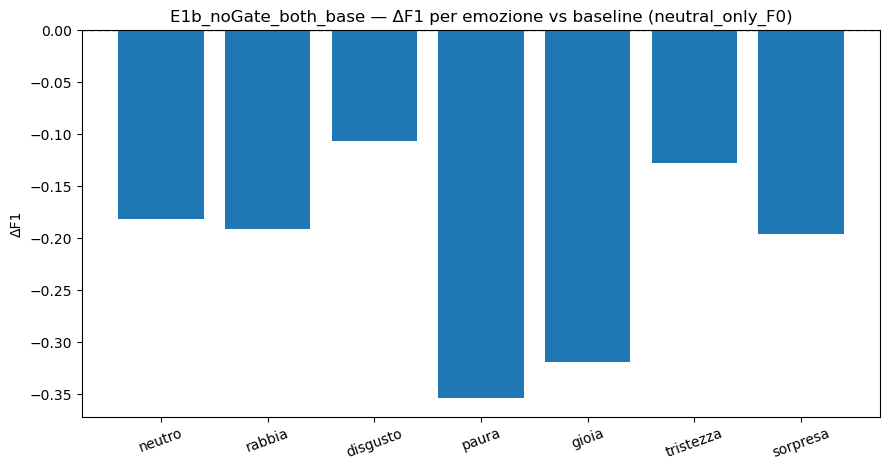

[saved] reports/plots__neutral_only_F0/dF1_E1b_noGate_both_base.png


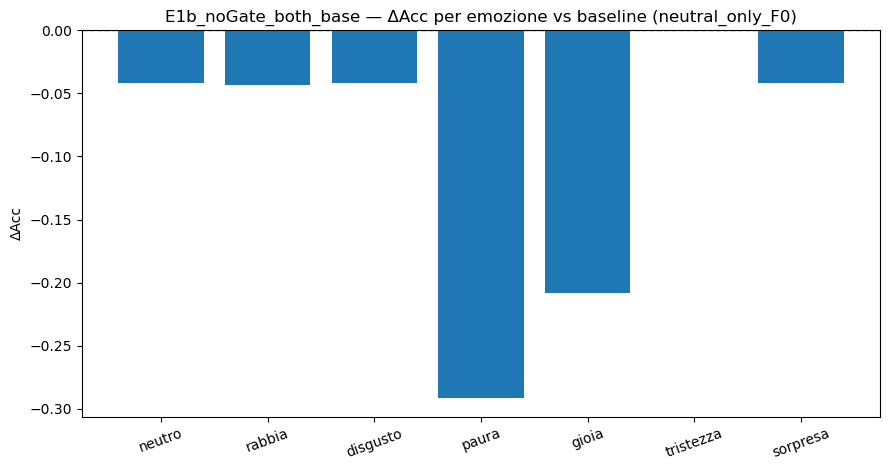

[saved] reports/plots__neutral_only_F0/dAcc_E1b_noGate_both_base.png


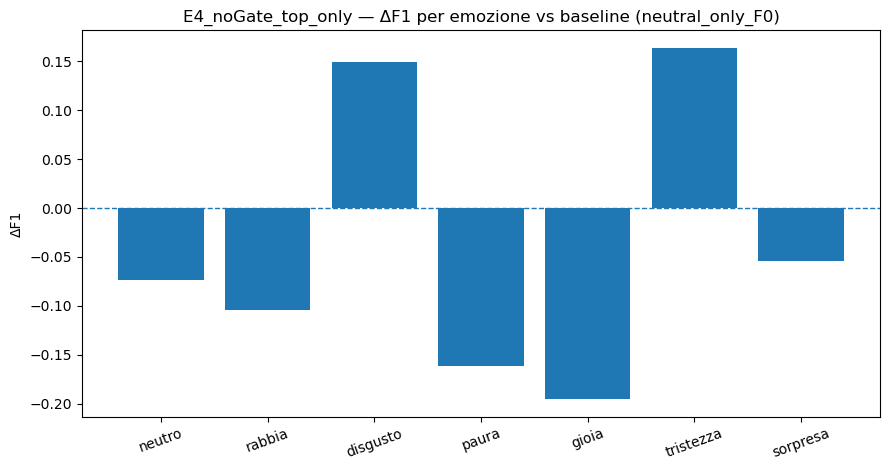

[saved] reports/plots__neutral_only_F0/dF1_E4_noGate_top_only.png


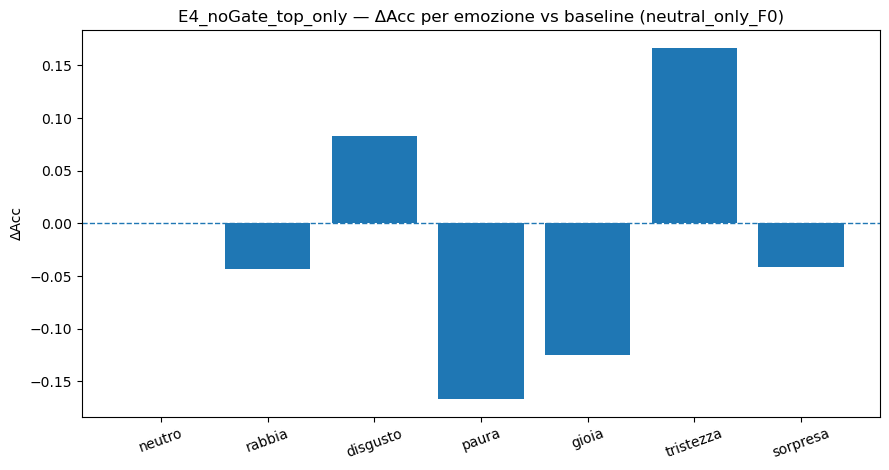

[saved] reports/plots__neutral_only_F0/dAcc_E4_noGate_top_only.png


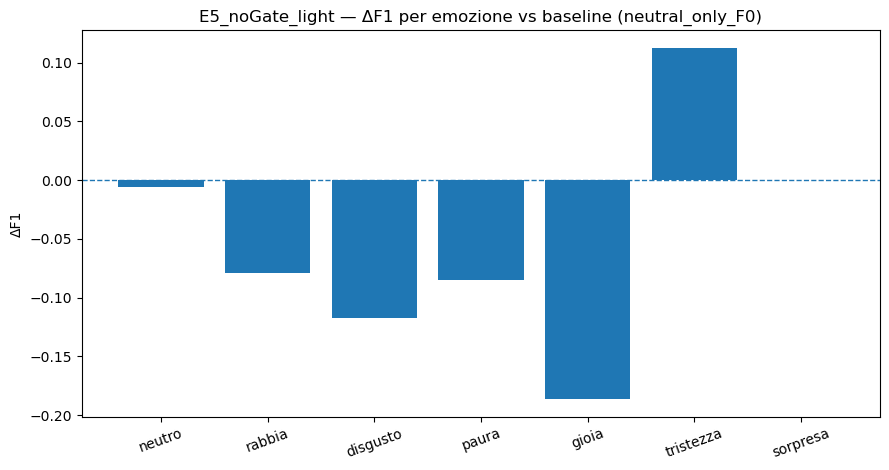

[saved] reports/plots__neutral_only_F0/dF1_E5_noGate_light.png


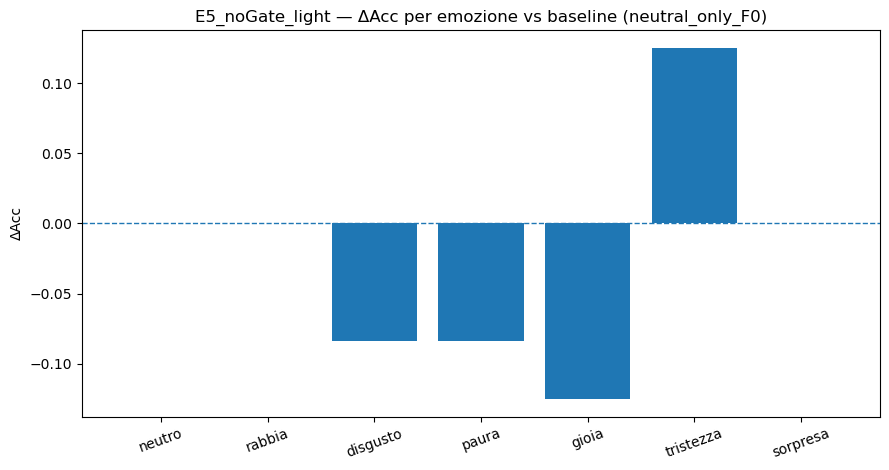

[saved] reports/plots__neutral_only_F0/dAcc_E5_noGate_light.png


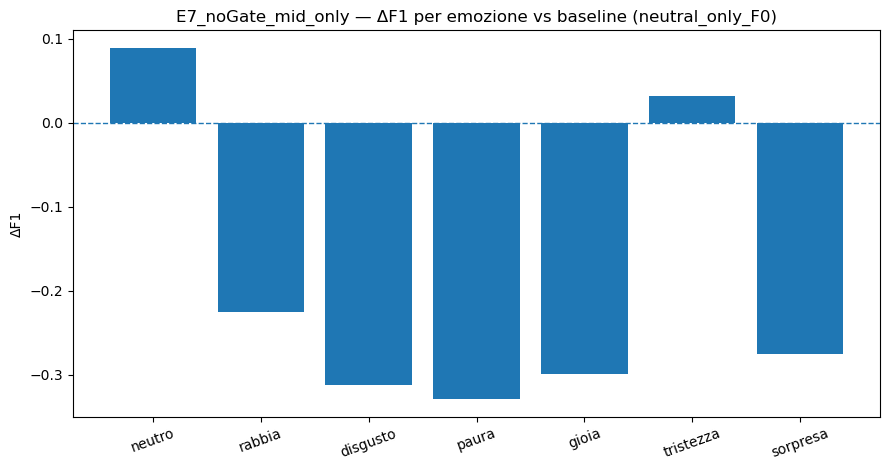

[saved] reports/plots__neutral_only_F0/dF1_E7_noGate_mid_only.png


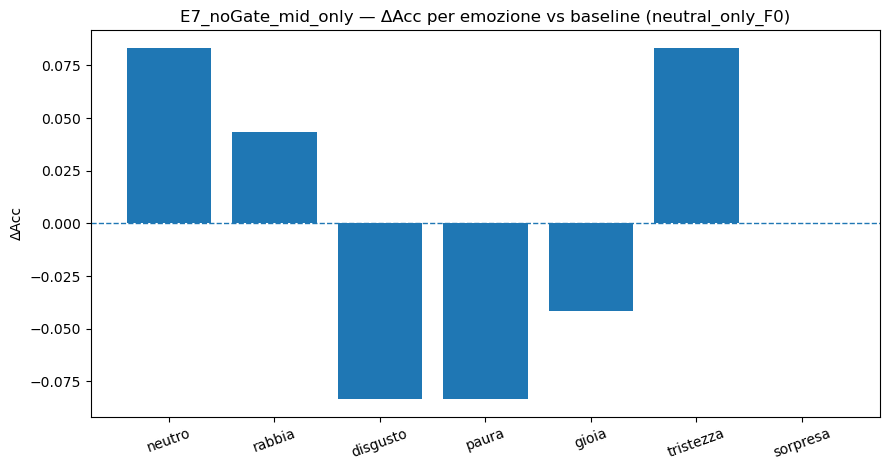

[saved] reports/plots__neutral_only_F0/dAcc_E7_noGate_mid_only.png

Tutti i PNG sono in: reports/plots__neutral_only_F0


In [36]:
# === PLOT per-emozione (ΔF1 e ΔAcc) per ogni esperimento — NO ZIP, PNG diretti ===
# Richiede che esistano i CSV generati dallo script precedente:
#  - reports/diagnose__<RUN>__<SPLIT>.csv
#  - (opz.) reports/posthoc__<SPLIT>/mcnemar_<RUN>.csv

import os, glob
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

SPLIT = "neutral_only_F0"  # cambia se vuoi "full_F0"
REPORTS_DIR = Path("reports")
PLOTS_DIR = REPORTS_DIR / f"plots__{SPLIT}"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Ordine "umano" delle emozioni (usa quello che hai nel dataset; filtra quelle non presenti)
EMOTION_ORDER = ["neutro","rabbia","disgusto","paura","gioia","tristezza","sorpresa"]

def _find_diagnose_files(split: str):
    pats = [
        str(REPORTS_DIR / f"diagnose__*__{split}.csv"),
        str(REPORTS_DIR / f"**/diagnose__*__{split}.csv"),
    ]
    files = []
    for p in pats:
        files.extend(glob.glob(p, recursive=True))
    # escludi baseline (di solito non ha diagnose)
    out = {}
    for f in sorted(files):
        name = Path(f).name  # es: diagnose__E5_noGate_light__neutral_only_F0.csv
        try:
            tag = name.split("diagnose__",1)[1].split("__",1)[0]
        except Exception:
            continue
        out[tag] = f
    return out

def _maybe_load_mcnemar(split: str, tag: str):
    p = REPORTS_DIR / f"posthoc__{split}" / f"mcnemar_{tag}.csv"
    return pd.read_csv(p) if p.exists() else None

def _emotion_order_index(names):
    # indicizza secondo EMOTION_ORDER, lasciando alla fine eventuali emozioni "fuori ordine"
    order_map = {e:i for i,e in enumerate(EMOTION_ORDER)}
    return sorted(range(len(names)), key=lambda i: order_map.get(names[i], 10_000+i))

def _plot_per_emotion_bar(df_diag: pd.DataFrame, df_mcn: pd.DataFrame|None, tag: str, split: str, metric: str):
    """
    metric: 'ΔF1' oppure 'ΔAcc'
    Aggiunge un asterisco su barre con FDR_sig_0.05=True (se df_mcn disponibile).
    """
    if metric not in df_diag.columns:
        raise ValueError(f"Colonna '{metric}' non trovata in diagnosi {tag} ({split}). Colonne: {list(df_diag.columns)}")

    # ordina le emozioni secondo EMOTION_ORDER (solo quelle presenti)
    emos = df_diag["emotion"].astype(str).tolist()
    idx_order = _emotion_order_index(emos)
    df_plot = df_diag.iloc[idx_order].reset_index(drop=True)

    x = np.arange(len(df_plot))
    y = df_plot[metric].values
    emo_labels = df_plot["emotion"].astype(str).tolist()

    # setup figura
    plt.figure(figsize=(9, 4.8))
    ax = plt.gca()
    ax.bar(x, y)  # nessun colore esplicito
    ax.axhline(0.0, linestyle="--", linewidth=1)

    # asterischi per significatività (se disponibile)
    if df_mcn is not None and "FDR_sig_0.05" in df_mcn.columns:
        # allinea sulle stesse emozioni/ordine
        sig_map = {str(r["emotion"]): bool(r["FDR_sig_0.05"]) for _,r in df_mcn.iterrows()}
        for i, emo in enumerate(emo_labels):
            if sig_map.get(emo, False):
                y_i = y[i]
                # posiziona l'asterisco appena sopra (o sotto) la barra
                delta = 0.03 * (np.nanmax(np.abs(y)) if np.nanmax(np.abs(y))>0 else 1.0)
                ax.text(x[i], y_i + (delta if y_i >= 0 else -delta), "*", ha="center", va="bottom" if y_i>=0 else "top", fontsize=14)

    ax.set_xticks(x)
    ax.set_xticklabels(emo_labels, rotation=20)
    ax.set_ylabel(metric)
    ax.set_title(f"{tag} — {metric} per emozione vs baseline ({split})")
    plt.tight_layout()

    # salva PNG e mostra
    out_png = PLOTS_DIR / f"{metric.replace('Δ','d')}_{tag}.png"
    plt.savefig(out_png, dpi=160)
    plt.show()
    print(f"[saved] {out_png}")

# --------- MAIN: scansiona diagnosi e plottale tutte ---------
diag_files = _find_diagnose_files(SPLIT)
if not diag_files:
    raise FileNotFoundError(f"Nessun diagnose__*__{SPLIT}.csv trovato in {REPORTS_DIR}. Esegui prima lo script di diagnosi.")

print("Trovate diagnosi per le run:", ", ".join(sorted(diag_files.keys())))

for tag, path_diag in sorted(diag_files.items()):
    df_diag = pd.read_csv(path_diag)
    df_mcn  = _maybe_load_mcnemar(SPLIT, tag)

    # plot ΔF1
    _plot_per_emotion_bar(df_diag, df_mcn, tag, SPLIT, metric="ΔF1")
    # plot ΔAcc
    _plot_per_emotion_bar(df_diag, df_mcn, tag, SPLIT, metric="ΔAcc")

print(f"\nTutti i PNG sono in: {PLOTS_DIR}")


In [35]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Per-emotion analysis + McNemar significance (FDR) per tutte le run.

- Baseline: 'E0_noKD'
- Per ciascuno split ('full_F0', 'neutral_only_F0'):
    • trova la baseline più recente
    • per ogni altra run nello stesso split:
        - calcola ΔAcc e ΔF1 per emozione (vs baseline)
        - stima McNemar per emozione da TEST__preds.csv (two-sided exact)
        - applica FDR 0.05
        - salva CSV di diagnosi e McNemar
        - genera due grafici (ΔF1, ΔAcc) con * sulle emozioni significative
- Salva tutto sotto reports/
- Crea anche uno ZIP con tutti i plot.

Nota: l’allineamento per McNemar assume che l’ordine del test loader sia identico
tra baseline e KD (com’è nella tua pipeline). In caso contrario, adegua qui
aggiungendo un ID stabile nella generazione dei preds.
"""

import os, glob, warnings, zipfile
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import comb

# ──────────────────────────────────────────────────────────────────────────────
# Config
# ──────────────────────────────────────────────────────────────────────────────
REPORTS_DIR = Path("reports")
SPLITS = ["full_F0", "neutral_only_F0"]          # modifica se serve
BASE_TAG = "E0_noKD"

# Metti None per considerare "tutte" le run trovate (eccetto baseline).
# In alternativa specifica i tag che vuoi plottare.
RUN_TAGS = None
# RUN_TAGS = ["E1b_noGate_both_base","E4_noGate_top_only","E5_noGate_light","E7_noGate_mid_only"]

EMOTIONS_ORDER = ["neutro","rabbia","disgusto","paura","gioia","tristezza","sorpresa"]
ALPHA_FDR = 0.05

# ──────────────────────────────────────────────────────────────────────────────
# Helpers: file system
# ──────────────────────────────────────────────────────────────────────────────
def _find_latest_report_dir(tag: str, split: str) -> Path | None:
    pats = [f"{REPORTS_DIR}/*{tag}*__{split}", f"{REPORTS_DIR}/**/*{tag}*__{split}"]
    cands = []
    for p in pats:
        cands += glob.glob(p, recursive=True)
    if not cands:
        return None
    cands.sort(key=lambda p: os.path.getmtime(p))
    return Path(cands[-1])

def _ensure_test_files(run_dir: Path):
    req = ["TEST__per_emotion.csv", "TEST__preds.csv"]
    miss = [f for f in req if not (run_dir / f).exists()]
    if miss:
        raise FileNotFoundError(f"Mancano file {miss} in {run_dir}")

def _load_per_emotion(run_dir: Path) -> pd.DataFrame:
    df = pd.read_csv(run_dir / "TEST__per_emotion.csv")
    need = {"emotion","acc","macro_f1"}
    if not need.issubset(df.columns):
        raise ValueError(f"Colonne mancanti in {run_dir/'TEST__per_emotion.csv'}; attese {need}")
    return df

def _load_preds(run_dir: Path) -> pd.DataFrame:
    p = run_dir / "TEST__preds.csv"
    df = pd.read_csv(p)
    need = {"y","yhat","emotion","prob_en","prob_it","prob_es"}
    if not need.issubset(df.columns):
        raise ValueError(f"Colonne mancanti in {p}; attese {need}")
    return df

# ──────────────────────────────────────────────────────────────────────────────
# Helpers: McNemar + FDR
# ──────────────────────────────────────────────────────────────────────────────
def mcnemar_exact_p(b: int, c: int) -> float:
    """Two-sided exact binomial McNemar: p = 2 * sum_{i<=min(b,c)} C(b+c, i) * 0.5^(b+c)."""
    n = b + c
    if n == 0:
        return np.nan
    k = min(b, c)
    tail = sum(comb(n, i) for i in range(0, k+1))
    p = 2.0 * tail * (0.5 ** n)
    return float(min(p, 1.0))

def fdr_bh(pvals: list[float], alpha: float = 0.05) -> np.ndarray:
    pv = np.array([np.nan if (p is None) else p for p in pvals], dtype=float)
    m = np.sum(~np.isnan(pv))
    if m == 0:
        return np.array([False]*len(pv))
    order = np.argsort(pv)
    rank = np.empty_like(order)
    rank[order] = np.arange(1, len(pv)+1)
    thresh = alpha * rank / m
    sig = pv <= thresh
    max_k = np.where(sig)[0].max() if sig.any() else -1
    if max_k >= 0:
        sig = np.zeros_like(sig, dtype=bool)
        sig[order[:max_k+1]] = True
    return sig

def mcnemar_per_emotion(base_preds: pd.DataFrame, kd_preds: pd.DataFrame) -> pd.DataFrame:
    """Restituisce: emotion, N, b, c, mcnemar_p, FDR_sig_0.05."""
    if len(base_preds) != len(kd_preds):
        raise ValueError("Predictions length mismatch tra baseline e KD.")
    rows = []
    # grouping by emotion; assumiamo stesso ordine del loader → allineamento per indice
    for emo, g_base in base_preds.groupby("emotion"):
        idx = g_base.index
        g_kd = kd_preds.loc[idx]
        y   = g_base["y"].values
        base_correct = (g_base["yhat"].values == y)
        kd_correct   = (g_kd["yhat"].values == y)
        b = int(np.sum((base_correct == 1) & (kd_correct == 0)))  # baseline giusta, kd sbaglia
        c = int(np.sum((base_correct == 0) & (kd_correct == 1)))  # baseline sbaglia, kd giusta
        p = mcnemar_exact_p(b, c)
        rows.append({"emotion": emo, "N": int(len(g_base)), "b": b, "c": c, "mcnemar_p": p})
    out = pd.DataFrame(rows).sort_values("emotion")
    out["FDR_sig_0.05"] = fdr_bh(out["mcnemar_p"].tolist(), alpha=ALPHA_FDR)
    return out

# ──────────────────────────────────────────────────────────────────────────────
# Δ per-emozione (Acc/F1) e merge con McNemar
# ──────────────────────────────────────────────────────────────────────────────
def compute_delta_tables_with_stats(base_dir: Path, kd_dir: Path) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Ritorna:
      - delta_df: emotion, acc_base, acc_kd, ΔAcc, macro_f1_base, macro_f1_kd, ΔF1 (+ eventuali ΔECE)
      - mcn_df:   emotion, N, b, c, mcnemar_p, FDR_sig_0.05
      - merged:   delta_df + mcn_df (merge on 'emotion')
    """
    _ensure_test_files(base_dir)
    _ensure_test_files(kd_dir)

    # Δ per-emozione da TEST__per_emotion.csv
    pe_base = _load_per_emotion(base_dir).rename(columns={"acc":"acc_base","macro_f1":"macro_f1_base"})
    pe_kd   = _load_per_emotion(kd_dir).rename(columns={"acc":"acc_kd","macro_f1":"macro_f1_kd"})
    delta_df = pe_kd.merge(pe_base, on="emotion", how="inner")
    delta_df["ΔAcc"] = delta_df["acc_kd"] - delta_df["acc_base"]
    delta_df["ΔF1"]  = delta_df["macro_f1_kd"] - delta_df["macro_f1_base"]

    # (opzionale) ECE
    eceb = base_dir / "TEST__ece_per_emotion.csv"
    ecek = kd_dir   / "TEST__ece_per_emotion.csv"
    if eceb.exists() and ecek.exists():
        eb = pd.read_csv(eceb).rename(columns={"ECE":"ECE_base"})
        ek = pd.read_csv(ecek).rename(columns={"ECE":"ECE_kd"})
        delta_df = delta_df.merge(ek, on="emotion", how="left").merge(eb, on="emotion", how="left")
        delta_df["ΔECE"] = delta_df["ECE_kd"] - delta_df["ECE_base"]

    # McNemar per-emozione da TEST__preds.csv
    base_preds = _load_preds(base_dir)
    kd_preds   = _load_preds(kd_dir)
    mcn_df = mcnemar_per_emotion(base_preds, kd_preds)

    # Merge + ordering
    merged = delta_df.merge(mcn_df, on="emotion", how="left")
    if set(EMOTIONS_ORDER).issuperset(set(merged["emotion"].unique())):
        merged["__ord"] = merged["emotion"].map({e:i for i,e in enumerate(EMOTIONS_ORDER)})
        merged = merged.sort_values("__ord").drop(columns="__ord")
        delta_df = merged[[c for c in delta_df.columns if c in merged.columns]]
        mcn_df   = merged[[c for c in mcn_df.columns if c in merged.columns]]

    return delta_df, mcn_df, merged

# ──────────────────────────────────────────────────────────────────────────────
# Plotting
# ──────────────────────────────────────────────────────────────────────────────
def plot_delta_bar(merged_df: pd.DataFrame, metric: str, title: str, out_png: Path):
    """
    Grafico a barre orizzontali per 'metric' (ΔF1 oppure ΔAcc).
    Barre annotate con valore e * per FDR_sig_0.05.
    """
    if metric not in merged_df.columns:
        warnings.warn(f"Metric '{metric}' non presente; skip {out_png.name}")
        return

    df = merged_df.copy()
    # ordine emozioni noto
    if set(EMOTIONS_ORDER).issuperset(set(df["emotion"].unique())):
        df["__ord"] = df["emotion"].map({e:i for i,e in enumerate(EMOTIONS_ORDER)})
        df = df.sort_values("__ord").drop(columns="__ord")
    else:
        df = df.sort_values("emotion")

    emos = df["emotion"].tolist()
    vals = df[metric].astype(float).values
    sigs = df.get("FDR_sig_0.05", pd.Series([False]*len(df))).astype(bool).values

    y = np.arange(len(emos))
    plt.figure(figsize=(8.0, 4.8))
    plt.barh(y, vals)
    plt.axvline(0.0, linestyle="--", linewidth=1)

    for i, (v, s) in enumerate(zip(vals, sigs)):
        label = f"{v:+.3f}" + (" *" if s else "")
        plt.text(v + (0.01 if v>=0 else -0.01), i, label,
                 va="center", ha="left" if v>=0 else "right", fontsize=9)

    plt.yticks(y, emos)
    plt.xlabel(metric)
    plt.title(title + ("  ( * = FDR<0.05 )" if sigs.any() else ""))
    plt.tight_layout()
    out_png.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_png, dpi=160)
    plt.close()

def zip_dir(src_dir: Path, zip_path: Path):
    with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zf:
        for p in src_dir.rglob("*"):
            if p.is_file():
                zf.write(p, p.relative_to(src_dir))

# ──────────────────────────────────────────────────────────────────────────────
# Main
# ──────────────────────────────────────────────────────────────────────────────
def main():
    if not REPORTS_DIR.exists():
        raise SystemExit("Cartella 'reports/' non trovata.")

    out_root = REPORTS_DIR / "plots_per_emotion_ALL"
    out_root.mkdir(parents=True, exist_ok=True)

    for split in SPLITS:
        print(f"\n=== Split: {split} ===")
        base_dir = _find_latest_report_dir(BASE_TAG, split)
        if base_dir is None:
            print(f"  [WARN] baseline '{BASE_TAG}' non trovata per split={split}. Salto.")
            continue

        # scopri tutte le run per lo split (tranne baseline)
        candidates = sorted(glob.glob(f"{REPORTS_DIR}/*__{split}"))
        runs = []
        for c in candidates:
            cpath = Path(c)
            tag = cpath.name.split("__")[0]
            if tag == BASE_TAG:
                continue
            if RUN_TAGS is not None and tag not in RUN_TAGS:
                continue
            runs.append((tag, cpath))

        if not runs:
            print(f"  [WARN] Nessuna run trovata per split={split}.")
            continue

        out_dir_split = out_root / split
        out_dir_split.mkdir(parents=True, exist_ok=True)

        # cartella per CSV McNemar
        posthoc_dir = REPORTS_DIR / f"posthoc__{split}"
        posthoc_dir.mkdir(parents=True, exist_ok=True)

        for tag, kd_dir in runs:
            try:
                delta_df, mcn_df, merged = compute_delta_tables_with_stats(base_dir, kd_dir)
            except Exception as e:
                print(f"  [WARN] Skip {tag}: {e}")
                continue

            # salva CSV diagnosi e McNemar
            diag_csv = REPORTS_DIR / f"diagnose__{tag}__{split}.csv"
            diag_stats_csv = REPORTS_DIR / f"diagnose__{tag}__{split}__with_stats.csv"
            mcn_csv  = posthoc_dir / f"mcnemar_{tag}.csv"

            # tabelle pulite
            delta_df.to_csv(diag_csv, index=False)
            merged.to_csv(diag_stats_csv, index=False)
            mcn_df.to_csv(mcn_csv, index=False)

            print(f"  [saved] {diag_csv.name}, {diag_stats_csv.name}, posthoc__ mcnemar_{tag}.csv")

            # plot ΔF1 e ΔAcc con marcatori di significatività
            title_f1  = f"{tag} vs {BASE_TAG} — {split} — ΔF1 per emozione"
            title_acc = f"{tag} vs {BASE_TAG} — {split} — ΔAccuracy per emozione"
            out_f1  = out_dir_split / f"{tag}__{split}__deltaF1.png"
            out_acc = out_dir_split / f"{tag}__{split}__deltaACC.png"

            plot_delta_bar(merged, "ΔF1",  title_f1,  out_f1)
            plot_delta_bar(merged, "ΔAcc", title_acc, out_acc)

            print(f"  [saved] {out_f1.name}, {out_acc.name}")

    # zip di tutti i plot
    zip_path = REPORTS_DIR / "plots_per_emotion_ALL.zip"
    zip_dir(out_root, zip_path)
    print(f"\n[ZIP] {zip_path} creato.")

if __name__ == "__main__":
    main()



=== Split: full_F0 ===
  [WARN] baseline 'E0_noKD' non trovata per split=full_F0. Salto.

=== Split: neutral_only_F0 ===
  [WARN] baseline 'E0_noKD' non trovata per split=neutral_only_F0. Salto.

[ZIP] reports/plots_per_emotion_ALL.zip creato.


In [ ]:
# === POST-STEP: Analisi significatività per emozione (aggiornato con E4) ===
import os, glob, json, math
import numpy as np
import pandas as pd
from pathlib import Path

REPORTS_DIR = Path("reports")

# scegli split e quali run confrontare
SPLIT = "full_F0"  # "full_F0" | "neutral_only_F0"
BASE_TAG = "E0_noKD"
# aggiunto E4 top-only
KD_TAGS  = [
    "E0_noKD",
    "E1b_noGate_both_base",
    "E4_noGate_top_only",
    "E5_noGate_light",
    "E7_noGate_mid_only",
]

def pick_run_dir_or_none(tag, split):
    cand = sorted(glob.glob(f"{REPORTS_DIR}/*{tag}*__{split}"))
    return cand[-1] if cand else None

base_dir = pick_run_dir_or_none(BASE_TAG, SPLIT)
if base_dir is None:
    raise FileNotFoundError(f"Nessun report baseline per tag={BASE_TAG} split={SPLIT}")
kd_dirs = {k: d for k in KD_TAGS if (d := pick_run_dir_or_none(k, SPLIT)) is not None}

print("BASE:", base_dir)
print("KD trovate:", kd_dirs)

# carica preds (stessa ordine del test loader)
def load_preds_csv(run_dir: str|Path):
    p = Path(run_dir)/"TEST__preds.csv"
    df = pd.read_csv(p)
    req = ["y","yhat","emotion","prob_en","prob_it","prob_es"]
    miss = [c for c in req if c not in df.columns]
    if miss: raise ValueError(f"Mancano colonne in {p}: {miss}")
    return df

base_df = load_preds_csv(base_dir)
kd_dfs  = {k: load_preds_csv(v) for k,v in kd_dirs.items()}

# sanity: stesse lunghezze
for k,df in kd_dfs.items():
    assert len(df)==len(base_df), f"Lunghezze diverse tra {k} e baseline"
print(f"N test = {len(base_df)}")

from math import comb

def mcnemar_exact_p(b, c):
    n = b + c
    if n == 0: return np.nan
    k = min(b, c)
    tail = sum(comb(n, i) for i in range(0, k+1))
    p = 2.0 * tail * (0.5 ** n)
    return float(min(p, 1.0))

def fdr_bh(pvals, alpha=0.05):
    pv = np.array([np.nan if (p is None) else p for p in pvals], dtype=float)
    m = np.sum(~np.isnan(pv))
    if m == 0: return np.array([False]*len(pv))
    order = np.argsort(pv)
    rank = np.empty_like(order); rank[order] = np.arange(1, len(pv)+1)
    thresh = alpha * rank / m
    sig = pv <= thresh
    max_k = np.where(sig)[0].max() if sig.any() else -1
    if max_k >= 0:
        sig = np.zeros_like(sig, dtype=bool); sig[order[:max_k+1]] = True
    return sig

def per_emotion_delta_and_mcnemar(base_df, kd_df):
    rows=[]
    for emo, g_base in base_df.groupby("emotion"):
        g_kd = kd_df.iloc[g_base.index]  # allineamento per indice
        y   = g_base["y"].values
        b_c = (g_base["yhat"].values == y)
        k_c = (g_kd["yhat"].values == y)
        b = np.sum((b_c == 1) & (k_c == 0))  # baseline right, kd wrong
        c = np.sum((b_c == 0) & (k_c == 1))  # baseline wrong, kd right
        p = mcnemar_exact_p(b, c)

        from sklearn.metrics import accuracy_score, f1_score
        acc_b = accuracy_score(y, g_base["yhat"].values) if len(y) else np.nan
        acc_k = accuracy_score(y, g_kd["yhat"].values)   if len(y) else np.nan
        f1_b  = f1_score(y, g_base["yhat"].values, average="macro") if len(y) else np.nan
        f1_k  = f1_score(y, g_kd["yhat"].values,   average="macro") if len(y) else np.nan

        rows.append({
            "emotion": emo,
            "N": int(len(g_base)),
            "b": int(b), "c": int(c), "mcnemar_p": p,
            "acc_base": acc_b, "acc_kd": acc_k, "ΔAcc": acc_k-acc_b,
            "F1_base": f1_b,  "F1_kd":  f1_k,   "ΔF1": f1_k-f1_b
        })
    out = pd.DataFrame(rows).sort_values("emotion")
    out["FDR_sig_0.05"] = fdr_bh(out["mcnemar_p"].values, alpha=0.05)
    return out

# genera tabelle per ciascuna KD e salva
OUT_DIR = REPORTS_DIR / f"posthoc__{SPLIT}"
OUT_DIR.mkdir(parents=True, exist_ok=True)

tables = {}
for tag, dfk in kd_dfs.items():
    tbl = per_emotion_delta_and_mcnemar(base_df, dfk)
    tables[tag] = tbl
    p_csv = OUT_DIR / f"mcnemar_{tag}.csv"
    tbl.to_csv(p_csv, index=False)
    print(f"[saved] {p_csv}")

# riassunto rapido
for tag,tbl in tables.items():
    print(f"\n== {tag} ==")
    print(tbl[["emotion","N","ΔF1","ΔAcc","mcnemar_p","FDR_sig_0.05"]].to_string(index=False))

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

PLOTS_DIR = OUT_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

def reliability_plot(df, title, out_png):
    probs = df[["prob_en","prob_it","prob_es"]].values
    yhat  = probs.argmax(1)
    y     = df["y"].values
    conf  = probs.max(1)
    correct = (yhat == y).astype(int)
    frac_pos, mean_pred = calibration_curve(correct, conf, n_bins=12, strategy="uniform")
    plt.figure(figsize=(4.8,4.8))
    plt.plot([0,1],[0,1], linestyle="--", label="perfetta")
    plt.plot(mean_pred, frac_pos, marker="o", label="osservata")
    plt.xlabel("Confidenza media nel bin")
    plt.ylabel("Accuratezza osservata")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_png, dpi=160)
    plt.close()

# funzione ΔF1 globale (macro)
def total_delta_F1(base, kd):
    from sklearn.metrics import f1_score
    return f1_score(base["y"].values, kd["yhat"].values, average="macro") - \
           f1_score(base["y"].values, base["yhat"].values, average="macro")

# scegli la KD migliore tra quelle presenti (potrebbe includere E4)
if len(kd_dfs)==0:
    raise RuntimeError("Nessuna KD trovata per lo split selezionato.")
best_tag = max(kd_dfs.keys(), key=lambda t: total_delta_F1(base_df, kd_dfs[t]))
print("KD migliore secondo ΔF1 globale:", best_tag)

# reliability globale (baseline vs best KD)
reliability_plot(base_df, f"Reliability — {BASE_TAG}", PLOTS_DIR/f"reliability_{BASE_TAG}.png")
reliability_plot(kd_dfs[best_tag], f"Reliability — {best_tag}", PLOTS_DIR/f"reliability_{best_tag}.png")
print(f"[saved] reliability plots in {PLOTS_DIR}")

# Radar per-emozione (F1): baseline vs KD migliore
import numpy as np

def radar_per_emotion(tbl_base, tbl_kd, tag_kd, out_png):
    emos = tbl_base["emotion"].tolist()
    f1b  = tbl_base["F1_base"].values
    f1k  = tbl_kd["F1_kd"].values
    angles = np.linspace(0, 2*np.pi, len(emos), endpoint=False).tolist()
    f1b_c = np.concatenate([f1b, f1b[:1]])
    f1k_c = np.concatenate([f1k, f1k[:1]])
    ang_c = angles + angles[:1]

    plt.figure(figsize=(6,6))
    ax = plt.subplot(111, polar=True)
    ax.plot(ang_c, f1b_c, linewidth=2, label="Baseline")
    ax.fill(ang_c, f1b_c, alpha=0.1)
    ax.plot(ang_c, f1k_c, linewidth=2, label=tag_kd)
    ax.fill(ang_c, f1k_c, alpha=0.1)
    ax.set_thetagrids(np.degrees(angles), emos)
    ax.set_title(f"Macro-F1 per emozione — {SPLIT}")
    ax.legend(loc="lower right", bbox_to_anchor=(1.25, -0.1))
    plt.tight_layout()
    plt.savefig(out_png, dpi=160, bbox_inches="tight")
    plt.close()

# usa una delle tabelle (qualsiasi KD) per recuperare i valori 'F1_base'
first_tag = next(iter(tables.keys()))
tbl_base = tables[first_tag][["emotion","F1_base"]].copy()
tbl_kd   = tables[best_tag]
radar_per_emotion(tbl_base, tbl_kd, best_tag, PLOTS_DIR/f"radar_per_emotion_{best_tag}.png")
print(f"[saved] radar in {PLOTS_DIR}")


FileNotFoundError: Nessun report baseline per tag=E0_noKD split=full_F0